# 1. Introduction
Across Africa’s rapidly evolving retail landscape, access to clean, reliable sales data remains one of the biggest challenges for consumer brands. Supermarket systems are fragmented, inconsistent, and often incomplete, making it difficult for manufacturers to understand how their products truly perform in-store.

## 1.1 Business Understanding
Bidco Africa is one of the largest Fast-Moving Consumer Goods (FMCG) manufacturers in East Africa, producing a diverse portfolio of everyday consumer products (including cooking oils, margarine, soaps, detergents, and juices) distributed through all major supermarket chains.

Operating in a competitive and price-sensitive retail environment, Bidco’s performance depends on its ability to understand product sales dynamics across different stores, categories, and regions. Retail execution, pricing consistency, and promotion effectiveness are key levers that directly influence both market share and profitability.

However, like many FMCG companies in emerging markets, Bidco’s visibility into retail performance is limited by fragmented, inconsistent, and incomplete data sourced from multiple supermarket systems. Without a reliable data layer, it becomes difficult to accurately assess how pricing and promotions drive sales or how Bidco’s products are positioned against competitors.

## 1.2 Problem Statement
Bidco’s commercial and marketing teams face a critical challenge:

>They need to understand how their products perform across different stores and categories, how pricing and promotions influence sales, and how their price positioning compares to competitors within each product segment.

The raw retail data provided by supermarket partners is complex and unstructured — often containing missing values, duplicate entries, and irregular pricing patterns. These issues undermine confidence in insights and decision-making.
Without a consistent analytical framework, Bidco cannot accurately answer questions such as:

1. Which SKUs drive the most sales uplift during promotions?
2. Where are Bidco’s prices too high or too low relative to competitors?
3. Are there specific stores or suppliers whose data cannot be trusted?

## Aim
The aim of this project is to engineer, validate, and analyze a week’s worth of raw supermarket sales data to create a trusted analytical layer that reveals how pricing, promotions, and competition affect Bidco’s product performance across stores and categories.

This work demonstrates how a data engineering pipeline can transform messy, transactional retail data into actionable commercial intelligence for brand and marketing teams.

## Objectives
To achieve this aim, the project is structured around three main objectives:

1. Data Health Assessment
* Audit the raw dataset for missing, duplicate, and anomalous records.
* Detect unreliable stores or suppliers based on data integrity.
* Assign a data quality score to quantify dataset reliability per entity.

2. Promotional & Performance Analysis
* Identify SKUs “on promotion” based on realized price drops relative to RRP.
*Compute promo uplift, coverage, and price impact metrics.
* Reveal which Bidco products benefit most from promotional activity and which categories show limited responsiveness.

3. Pricing Index Development
* Benchmark Bidco’s realized average prices against competitors within the same Sub-Department and Section across stores.
* Build a pricing index to classify Bidco’s positioning as premium, parity, or discount relative to peers.
* Highlight where price strategy shifts by region or retailer.

# 2. Data
The dataset represents one week of supermarket transactions collected across multiple stores and suppliers, containing approximately 30,691 rows and 13 columns.
Each record corresponds to a single SKU-level sale on a specific date and store, including information on quantities sold, sales value, and retail pricing.

This dataset mirrors the fragmented and inconsistent nature of retail data in emerging markets, where systems often differ between retailers, resulting in incomplete or misaligned records.
It provides a realistic environment to test data engineering and analytical approaches for cleaning, validation, and performance tracking.

**Key Characteristics**
* **Time Period:** 7 consecutive days of transactions
* **Granularity:** SKU-level sales per store per day
* **Volume:** 30,691 records
* **Coverage:** Multiple product categories, departments, sub-departments, and suppliers

## 2.1 Data Schema
| **Column**         | **Description**                                                                       |
| ------------------ | ------------------------------------------------------------------------------------- |
| **Store Name**     | Name of the retail outlet or branch.                          |
| **Item_Code**      | Unique internal identifier for the product within the retailer’s system.              |
| **Item Barcode**   | Standard barcode identifier (EAN/UPC).                                                |
| **Description**    | Human-readable SKU description.                                                       |
| **Category**       | Broad product grouping.                               |
| **Department**     | Mid-level grouping within a category (e.g., “Cooking Essentials”).                    |
| **Sub-Department** | More refined classification for analytical grouping.                                  |
| **Section**        | Micro-segmentation within the Sub-Department, often representing brand or format.     |
| **Quantity**       | Number of units sold during the transaction period.                                   |
| **Total Sales**    | Total value of items sold — calculated as *Quantity × Realized Price*.                |
| **RRP**            | Recommended Retail Price — benchmark price before discounts or promotions.            |
| **Supplier**       | Supplier or distributor for the product. |
| **Date Of Sale**   | Date of the transaction.                         |


## 2.2 Data Loading
Understand columns, data types, and quality issues

In [2]:
# Tools and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", font_scale=1.2)
%matplotlib inline

In [3]:
# Load Data
data = pd.read_excel('../data/Test_Data.xlsx')
# backup data 
df = data.copy()

In [4]:
# Data Shape
print(f"Loaded {len(df):,} rows and {df.shape[1]} columns")

Loaded 30,691 rows and 13 columns


## 2.3 Data Health

Every promotion you run, every price you set, and every sales forecast you trust begins with one simple truth: *your data must be healthy*. At Bidco, where decisions about products can move millions of shillings in a single week, a single error (a missing price, a negative sale, or a duplicated transaction) can lead to lost margin, wasted promotions, or misguided strategy. That’s why we built the **Data Health Pipeline**,  a fast, automated system that checks the health score of our data. It scans every row, flags hidden problems, and gives you a clear 0–100 health score before any analysis begins.

- Identify missing/duplicated records and suspicious outliers (negative quantities, extreme prices).
- Flag unreliable stores or suppliers.
- Produce a simple data health score per store or supplier and summarise key issues.


In [5]:
# ═══════════════════════════════════════════════════════════════════════════
# DATA HEALTH PIPELINE 
# ═══════════════════════════════════════════════════════════════════════════
def data_health_pipeline(df, 
                                   bidco_name='BIDCO AFRICA LIMITED',
                                   unhealthy_score_threshold=75):
    """
    Your exact checks + returns:
        • overall_score, rating
        • missing_columns_with_counts
        • negative_rows (full rows)
        • ONE visual showing ONLY unhealthy parts (always visible)
    """
    df = df.copy()
    print(f"Running FINAL health check on {len(df):,} rows...\n")

    # ────────────────────────────────
    # 1. MISSING VALUES – SHOW COUNT, NOT %
    # ────────────────────────────────
    missing_counts = df.isna().sum()
    missing_columns = missing_counts[missing_counts > 0]
    missing_columns_with_counts = missing_columns.to_dict() 

    # ────────────────────────────────
    # 2. DUPLICATES
    # ────────────────────────────────
    dup_mask = df.duplicated(subset=['Item_Code','Store Name','Date Of Sale'], keep=False)
    duplicates = df[dup_mask]
    dup_rate = (len(duplicates)/len(df)*100)

    # ────────────────────────────────
    # 3. NEGATIVE VALUES – RETURN FULL ROWS
    # ────────────────────────────────
    numeric_cols = ['Quantity', 'Total Sales', 'RRP']
    negative_rows = df[(df[numeric_cols] < 0).any(axis=1)].copy().reset_index(drop=True)

    # ────────────────────────────────
    # 4. RRP OUTLIERS (IQR per Item_Code)
    # ────────────────────────────────
    price_df = df[['Store Name','Item_Code','RRP']].dropna(subset=['RRP']).copy()

    def detect_outliers(g):
        Q1, Q3 = g['RRP'].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        g['Outlier'] = (g['RRP'] < lower) | (g['RRP'] > upper)
        return g

    outliers_df = price_df.groupby('Item_Code', group_keys=False).apply(detect_outliers)

    store_outlier_stats = (
        outliers_df.groupby('Store Name', as_index=False)
        .agg(total_products=('Item_Code','count'), outlier_count=('Outlier','sum'))
    )
    store_outlier_stats['outlier_rate'] = (
        store_outlier_stats['outlier_count'] / store_outlier_stats['total_products'].replace(0,1) * 100
    ).round(2)
    store_outlier_stats['Unreliable_Store'] = store_outlier_stats['outlier_rate'] > 10

    # ────────────────────────────────
    # 5. STORE-LEVEL HEALTH (your exact steps)
    # ────────────────────────────────
    store_health = (
        df.groupby('Store Name', as_index=False)
        .agg(
            total_rows=('Item_Code','count'),
            negative_rows=('Quantity', lambda x: (x < 0).sum()),
            missing_rrp=('RRP', lambda x: x.isna().sum())
        )
    )

    outlier_stats = outliers_df.groupby('Store Name', as_index=False).agg(outlier_count=('Outlier','sum'))
    store_health = store_health.merge(outlier_stats, on='Store Name', how='left').fillna({'outlier_count': 0})

    missing_cells = df.isna().groupby(df['Store Name']).sum().sum(axis=1).reset_index(name='total_missing_cells')
    missing_cells['total_possible_cells'] = df.groupby('Store Name').size().values * len(df.columns)
    missing_cells['pct_missing_all_cols'] = (missing_cells['total_missing_cells'] / missing_cells['total_possible_cells'] * 100).round(2)

    store_health = store_health.merge(missing_cells[['Store Name','pct_missing_all_cols']], on='Store Name', how='left')
    store_health = store_health.merge(store_outlier_stats[['Store Name','Unreliable_Store']], on='Store Name', how='left')
    store_health['Unreliable_Store'] = store_health['Unreliable_Store'].fillna(False)

    store_health['pct_negative']    = (store_health['negative_rows'] / store_health['total_rows'] * 100)
    store_health['pct_missing_rrp'] = (store_health['missing_rrp'] / store_health['total_rows'] * 100)
    store_health['pct_outliers']    = (store_health['outlier_count'] / store_health['total_rows'] * 100)

    # ────────────────────────────────
    # 6. YOUR SCORING FORMULA
    # ────────────────────────────────
    def compute_health_score(row):
        s = 100
        s -= row['pct_negative']      * 0.20
        s -= row['pct_missing_rrp']   * 0.15
        s -= row['pct_outliers']      * 0.30
        s -= row['pct_missing_all_cols'] * 0.25
        if row['Unreliable_Store']: s -= 10
        return max(round(s, 1), 0)

    store_health['Data_Health_Score'] = store_health.apply(compute_health_score, axis=1)

    # ────────────────────────────────
    # 7. OVERALL SCORE
    # ────────────────────────────────
    overall_score = (
        (store_health['Data_Health_Score'] * store_health['total_rows']).sum() /
        store_health['total_rows'].sum()
    ).round(1)

    def classify(score):
        if score >= 90: return "Excellent – ready for analysis"
        if score >= 75: return "Good – minor cleaning recommended"
        if score >= 60: return "Moderate – review key issues"
        return "Poor – significant cleaning required"

    overall_rating = classify(overall_score)

    # ────────────────────────────────
    # 8. ONE VISUAL – ALWAYS SHOWS UNHEALTHY PARTS
    # ────────────────────────────────
    parts = []

    # Missing columns (show count)
    if missing_columns_with_counts:
        miss_df = pd.DataFrame([
            {'Issue': 'Missing Values', 'Store Name': '(all)', 'Details': f"{col} → {cnt} rows"}
            for col, cnt in missing_columns_with_counts.items()
        ])
        parts.append(miss_df)

    # Negative rows (show key fields)
    if not negative_rows.empty:
        neg_summary = negative_rows[['Store Name', 'Item_Code', 'Description']].copy()
        neg_summary['Issue'] = 'Negative Value'
        neg_summary['Details'] = negative_rows[numeric_cols].apply(
            lambda r: ', '.join([f"{c}={v}" for c,v in r.items() if v < 0]), axis=1
        )
        parts.append(neg_summary)

    # Low-score stores
    bad_stores = store_health[store_health['Data_Health_Score'] < unhealthy_score_threshold] \
                     .sort_values('Data_Health_Score')[['Store Name', 'Data_Health_Score']]
    if not bad_stores.empty:
        bad = bad_stores.copy()
        bad['Issue'] = 'Low Health Score'
        bad['Details'] = bad['Data_Health_Score'].astype(str)
        bad = bad[['Issue', 'Store Name', 'Details']]
        parts.append(bad)

    unhealthy_df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # ─── PLOT: ALWAYS SHOWS (even 1–3 items) ───
    fig, ax = plt.subplots(figsize=(11, max(3.5, len(unhealthy_df) * 0.6)))
    
    if not unhealthy_df.empty:
        # Color by issue
        palette = {
            'Missing Values': '#E63946',
            'Negative Value': '#FF9F1C',
            'Low Health Score': '#9B59B6'
        }
        sns.barplot(
            data=unhealthy_df,
            y='Details',
            x='Store Name' if 'Store Name' in unhealthy_df.columns else 'Details',
            hue='Issue',
            dodge=False,
            palette=palette,
            ax=ax,
            orient='h'
        )
        ax.set_title('UNHEALTHY DATA – ACTION REQUIRED', fontsize=14, weight='bold', color='darkred')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.legend(title='Issue Type', bbox_to_anchor=(1.02, 1), loc='upper left')
        sns.despine()
    else:
        ax.text(0.5, 0.5, 'All data is healthy!', transform=ax.transAxes,
                fontsize=18, ha='center', va='center', color='green', weight='bold')
        ax.set_title('No Issues Found', fontsize=14, weight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # ────────────────────────────────
    # 9. FINAL OUTPUT
    # ────────────────────────────────
    print("\n" + "═" * 75)
    print(f"OVERALL DATA HEALTH SCORE : {overall_score}/100")
    print(f"ASSESSMENT                : {overall_rating}")
    print("═" * 75)

    if missing_columns_with_counts:
        print("MISSING VALUES (count):")
        for col, cnt in missing_columns_with_counts.items():
            print(f"   • {col}: {cnt} rows")
    if not negative_rows.empty:
        print(f"NEGATIVE VALUES: {len(negative_rows)} rows")
    if not bad_stores.empty:
        print(f"UNHEALTHY STORES (<{unhealthy_score_threshold}): {len(bad_stores)}")
    print("═" * 75)

    return {
        'overall_score': overall_score,
        'overall_rating': overall_rating,
        'store_health': store_health,
        'missing_columns_with_counts': missing_columns_with_counts,
        'negative_rows': negative_rows,
        'unhealthy_visual': fig,
        'unhealthy_summary': unhealthy_df
    }

#### Run Health Check

Running FINAL health check on 30,691 rows...



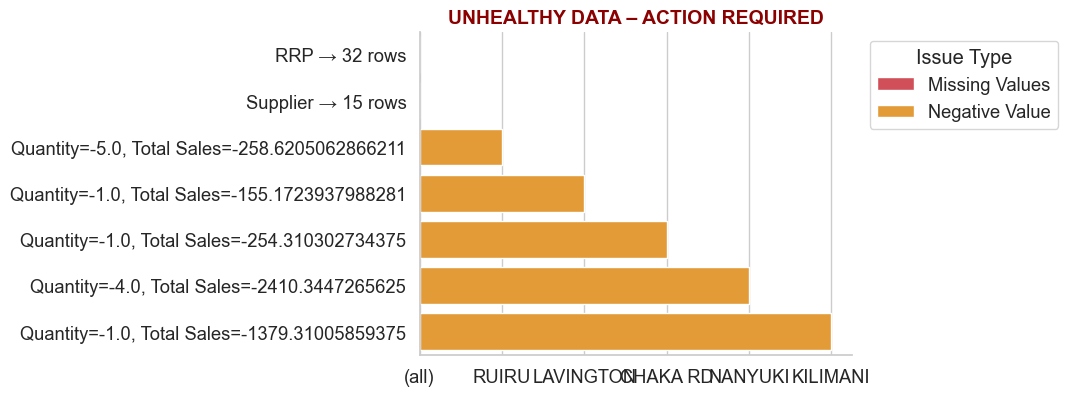


═══════════════════════════════════════════════════════════════════════════
OVERALL DATA HEALTH SCORE : 99.6/100
ASSESSMENT                : Excellent – ready for analysis
═══════════════════════════════════════════════════════════════════════════
MISSING VALUES (count):
   • RRP: 32 rows
   • Supplier: 15 rows
NEGATIVE VALUES: 5 rows
═══════════════════════════════════════════════════════════════════════════


In [6]:
# run health pipeline
results = data_health_pipeline(df)

#### Missing

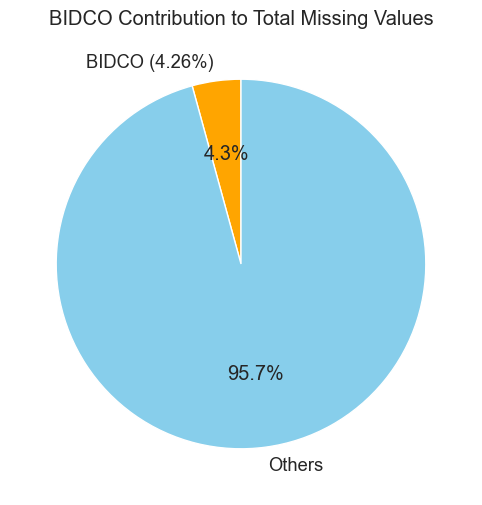

In [7]:
# Calculate numbers
total_missing = df.isna().sum().sum()
bidco_missing = df[df['Supplier'] == 'BIDCO AFRICA LIMITED'].isna().sum().sum()
other_missing = total_missing - bidco_missing

pct_bidco_of_total_missing = (bidco_missing / total_missing * 100).round(2)

plt.figure(figsize=(8,6))
plt.pie([pct_bidco_of_total_missing, 100-pct_bidco_of_total_missing],
        labels=[f'BIDCO ({pct_bidco_of_total_missing}%)', 'Others'],
        autopct='%1.1f%%',
        colors=['orange','skyblue'],
        startangle=90)
plt.title('BIDCO Contribution to Total Missing Values')
plt.show()

* Negative Quantity, Total Sales, RRP

In [8]:
# Filter rows where BOTH Quantity and Total Sales are negative
issues_df = df[
    (df['Quantity'] < 0) &
    (df['Total Sales'] < 0)
]

issues_df

,Store Name,Item_Code,Item Barcode,Description,Category,Department,Sub-Department,Section,Quantity,Total Sales,RRP,Supplier,Date Of Sale
4883,RUIRU,501371,7289468692169,FD-MIB SMALL BISCUITS 290G,FOODS,CONFECTIONERIES,BISCUITS,DIGESTIVES,-5.0,-258.620506,56.60,MIBISCO LTD,2025-09-28
6481,LAVINGTON,420937,6736792116879,FD-WINNIES PURE SEA SALT 500G,FOODS,SEASONING & CONDIMENTS,SALT,SEA SALT,-1.0,-155.172394,138.43,WINNIES PURE HEALTH PRODUCTS LIMITED,2025-09-27
10845,CHAKA RD,370037,7641101465908,FD-KKL PICK N PEEL TROPICAL MIX 1L SLIM,FOODS,JUICES AND CARBONATES,NON CARBONATED DRINKS,TETRA,-1.0,-254.310303,263.74,KEVIAN KENYA LTD,2025-09-28
25008,NANYUKI,684470,105975623057,FD-LCC-JINJA 64% BAR 70G,FOODS,CONFECTIONERIES,CHOCOLATE,CHOCO SNACK,-4.0,-2410.344727,573.79,SARAYA KENYA COMPANY LIMITED,2025-09-24
26492,KILIMANI,401433,8184711474155,PC-HKL PAMPERS PANTS JUMBO SIZE7 35S,PERSONAL CARE,DIAPERS AND WIPES,BABY DIAPERS,BABY DIAPER PANTS,-1.0,-1379.310059,1792.12,HASBAH KENYA LTD,2025-09-28


* Extreme price

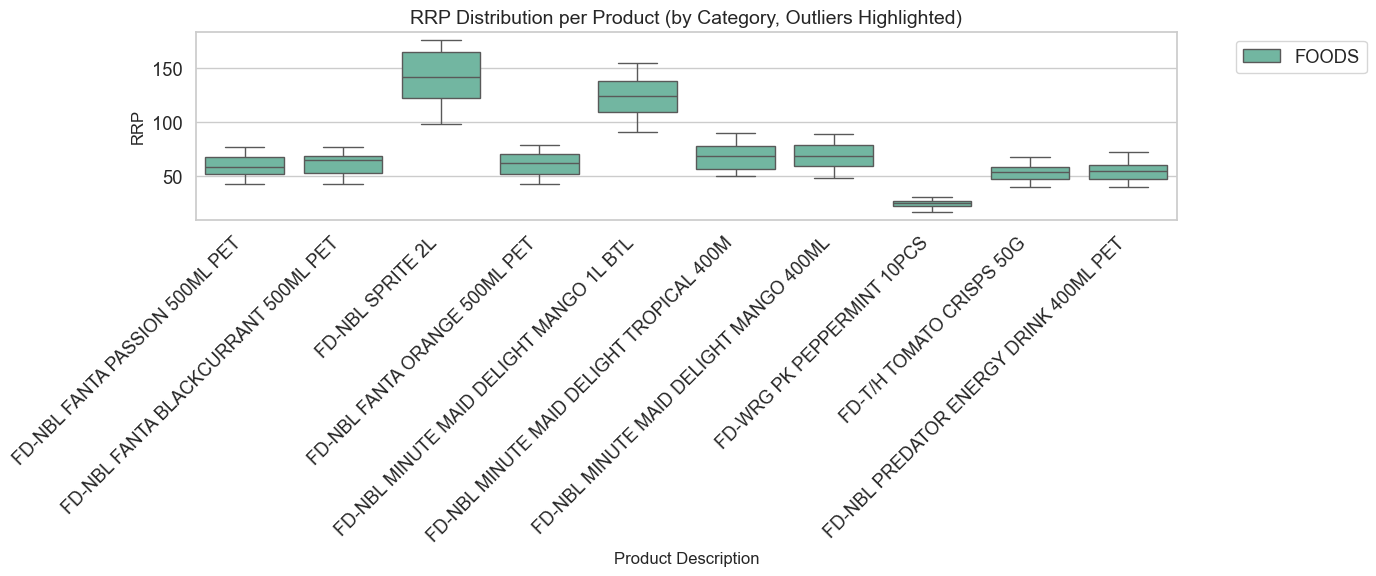

In [9]:
# --- Filter relevant columns ---
price_df = df[['Store Name', 'Item_Code', 'Description', 'Category', 'RRP', 'Supplier']].copy()
price_df = price_df.dropna(subset=['RRP'])

# --- Detect outliers using IQR per product ---
def detect_outliers(group):
    Q1 = group['RRP'].quantile(0.25)
    Q3 = group['RRP'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    group['Outlier'] = (group['RRP'] < lower) | (group['RRP'] > upper)
    return group

outliers_df = price_df.groupby('Item_Code', group_keys=False).apply(detect_outliers)

# --- Pick top N products to visualize ---
top_products = outliers_df['Description'].value_counts().head(10).index
plot_df = outliers_df[outliers_df['Description'].isin(top_products)]

# --- Plot ---
plt.figure(figsize=(14, 6))
sns.boxplot(
    x='Description', 
    y='RRP', 
    data=plot_df, 
    hue='Category', 
    showfliers=False, 
    palette='Set2'
)

# Overlay outliers as red points
sns.stripplot(
    x='Description', 
    y='RRP', 
    data=plot_df[plot_df['Outlier']], 
    color='red', 
    size=5, 
    jitter=True, 
    label='Outliers'
)

plt.title('RRP Distribution per Product (by Category, Outliers Highlighted)', fontsize=14)
plt.xlabel('Product Description', fontsize=12)
plt.ylabel('RRP', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 2.4 Dealing with Anomalous Data

Out of **30,691** total sales records, the data pipeline identified **52 anomalies**, accounting for **0.17%** of all transactions:

* **32 rows** missing `RRP` (0.10%)
* **15 rows** missing `Supplier` (0.05%)
* **5 rows** with negative `Quantity` and `Total Sales` (0.02%)

### Missing Supplier and RRP

* The **Supplier** field is critical for commercial attribution — without it, we cannot distinguish between manufacturers or accurately benchmark brand performance. Imputation or guessing would introduce bias, distort category share, and compromise supplier-level insights.
* The **RRP** (Recommended Retail Price) underpins all pricing, discount, and elasticity analyses. Records without RRP cannot support valid margin, promotion, or competitiveness evaluations. As such, these 32 entries were excluded to maintain analytical integrity.

In [10]:
# Droppinmg unhealthy data
print(f"Before drop: {len(df):,} rows")

# Drop rows where:
#   • RRP is missing
#   • Supplier is missing
#   • Quantity is negative
df_clean = df.dropna(subset=['RRP', 'Supplier']).copy()

print(f"After drop: {len(df_clean):,} rows")
print(f"Removed: {len(df)-len(df_clean)} rows ({((len(df)-len(df_clean))/len(df)*100):.2f}%)")



Before drop: 30,691 rows
After drop: 30,644 rows
Removed: 47 rows (0.15%)


### Negative Quantity and Sales Values
All five records showing negative `Quantity` and `Total Sales` occurred on the same transaction date `2025-09-28`, pointing to a  possible localized data capture or ETL sign inversion rather than genuine returns or reversals. Because `Total Sales = Quantity × RRP` remains consistent, these represent legitimate sales misrecorded with inverted signs. Applying a sign correction (instead of deletion) ensures data completeness, preserves financial accuracy, and sustains continuity across downstream KPIs and store performance metrics. This targeted structural adjustment corrects the anomaly at its source while maintaining both data integrity and business fidelity.

In [11]:
df_fixed = df_clean.copy()

# Identify rows where both Quantity and Total Sales are negative
mask = (df_fixed['Quantity'] < 0) & (df_fixed['Total Sales'] < 0)

df_fixed.loc[mask, ['Quantity', 'Total Sales']] = df_fixed.loc[mask, ['Quantity', 'Total Sales']].abs()

In [12]:
# Reset index for clean look
df_clean = df_fixed.reset_index(drop=True)

# Now use df_clean for all analysis
df = df_clean

##### Save the Cleaned Data

In [13]:
# # Save the cleaned dataset
# output_path = "../data/cleaned_sales_data.csv" 

# df.to_csv(output_path, index=False)

# print(f"Cleaned data saved successfully as: {output_path}")

#### Rerun Health Check On Cleaned Data

Running FINAL health check on 30,644 rows...



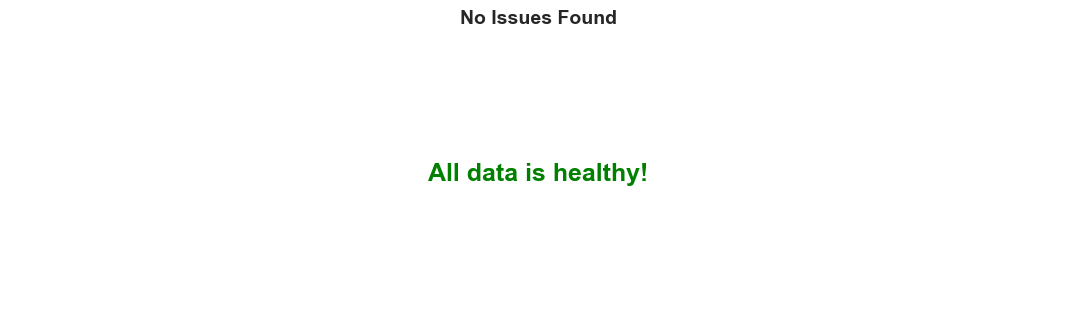


═══════════════════════════════════════════════════════════════════════════
OVERALL DATA HEALTH SCORE : 99.7/100
ASSESSMENT                : Excellent – ready for analysis
═══════════════════════════════════════════════════════════════════════════
═══════════════════════════════════════════════════════════════════════════


In [14]:
# check data health
results = data_health_pipeline(df)

# 3. EDA

In [15]:
# Load the cleaned data
output_path = "../data/cleaned_sales_data.csv" 

df = pd.read_csv(output_path)

### 3.1 Market Share Analysis: BIDCO AFRICA LIMITED

Total rows: 30654
BIDCO AFRICA LIMITED rows: 998
Percentage of overall data: 3.26%
Number of suppliers: 190


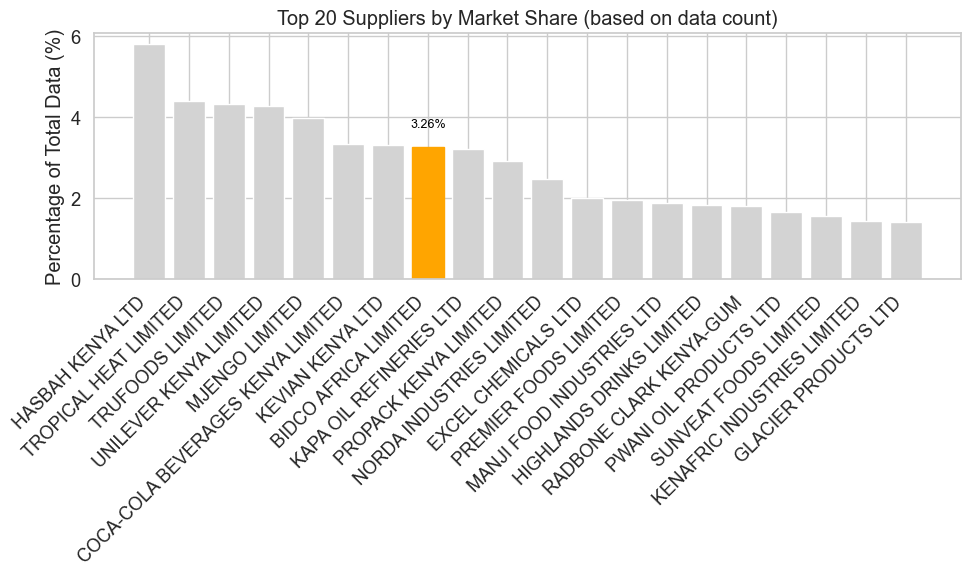

In [16]:
# Filter for BIDCO AFRICA LIMITED
bidco_df = df[df['Supplier'] == 'BIDCO AFRICA LIMITED']

# Calculate percentage of total rows
total_rows = len(df)
bidco_rows = len(bidco_df)
bidco_percentage = (bidco_rows / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"BIDCO AFRICA LIMITED rows: {bidco_rows}")
print(f"Percentage of overall data: {bidco_percentage:.2f}%")

# Count number of unique suppliers
num_suppliers = df['Supplier'].nunique()
print(f"Number of suppliers: {num_suppliers}")

# Market share (based on row count or total sales)
supplier_distribution = df['Supplier'].value_counts(normalize=True) * 100  # percentage share

# Visualize supplier market share
top_suppliers = supplier_distribution.head(20)  

plt.figure(figsize=(10,6))
bars = plt.bar(top_suppliers.index, top_suppliers.values, color='lightgrey')
plt.title("Top 20 Suppliers by Market Share (based on data count)")
plt.ylabel("Percentage of Total Data (%)")
plt.xticks(rotation=45, ha='right')

# Highlight BIDCO bar
for i, supplier in enumerate(top_suppliers.index):
    if supplier == 'BIDCO AFRICA LIMITED':
        bars[i].set_color('orange')
        plt.text(i, top_suppliers.values[i] + 0.5, f"{top_suppliers.values[i]:.2f}%", 
                 ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


An analysis of the supplier dataset reveals that **BIDCO AFRICA LIMITED contributes 3.26%** of the total entries. This indicates BIDCO holds a **modest share** within the overall supplier ecosystem.

* With a **3.26% representation**, BIDCO ranks as a **mid-tier supplier** in terms of presence within the dataset.
* While not among the dominant suppliers, BIDCO maintains a **consistent footprint**, suggesting stable product placement or category specialization rather than broad market penetration.

**Strategic Takeaways:**

* **Growth potential:** BIDCO could expand its share by increasing product range or distribution footprint.
* **Partnership opportunity:** If the brand aligns with key growth categories, deepening collaboration could improve overall category performance.
* **Benchmarking need:** Compare BIDCO’s 3.26% with top suppliers to identify gaps in assortment, pricing, or promotion.

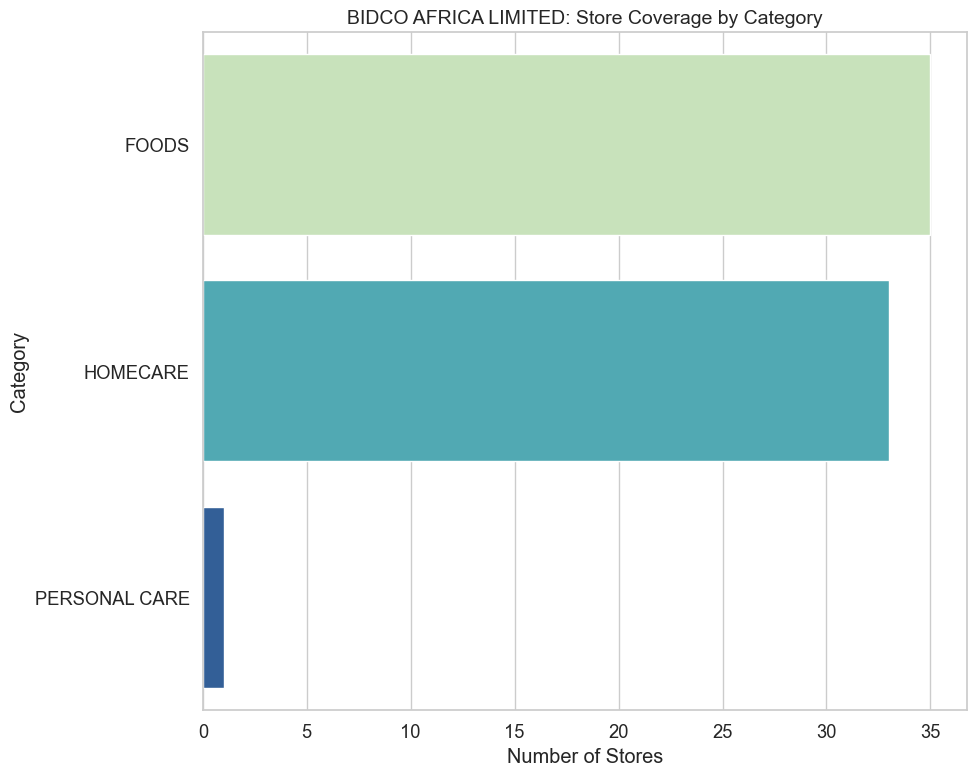

In [17]:
# Count how many stores Bidco supplies in each category
bidco_category_stores = (
    bidco_df.groupby('Category')['Store Name']
    .nunique()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,8))
sns.barplot(
    x=bidco_category_stores.values,
    y=bidco_category_stores.index,
    palette="YlGnBu",
    hue=bidco_category_stores.index
)
plt.title("BIDCO AFRICA LIMITED: Store Coverage by Category", fontsize=14)
plt.xlabel("Number of Stores")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


BIDCO AFRICA LIMITED shows full distribution strength in FOODS and HOMECARE but has minimal presence in PERSONAL CARE — representing both a gap and an opportunity for strategic category growth.

| **Category**                | **Stores Supplied**        | **Commercial Interpretation**                                                                                                                                                                                                             |
| --------------------------- | -------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **FOODS (35 stores)**       | Full coverage (100%)       | This is BIDCO’s **core strength** and primary revenue driver. The brand has full market penetration across all stores, reflecting strong demand, reliable supply chains, and trusted brand positioning.                                     |
| **HOMECARE (33 stores)**    | Near full coverage (~94%)  | BIDCO has an **established footprint** here too — indicating a mature product range and strong retailer partnerships. This category reinforces BIDCO’s diversification beyond foods and supports its position as a multi-category supplier. |
| **PERSONAL CARE (1 store)** | Extremely limited presence | This is a **significant underperformance** and likely represents a new or emerging line. There’s *substantial white-space opportunity* to scale this category if it aligns with BIDCO’s strategic priorities.                               |

# 4. Promotions & Performance

## 4.1 Detect likely promo periods.
We inferred likely promotional periods for each product by comparing its actual selling price to the recommended retail price (RRP).
If a product was sold at 10% or more below its RRP for 2 or more days within a week, we flagged that week as a likely promotion.
This approach provides a systematic, rule-based method to detect when products were on discount without needing explicit promo records from the stores.


In [18]:
# Date Of Sale is datetime
df['Date Of Sale'] = pd.to_datetime(df['Date Of Sale'])

# Step 1: Compute realized unit price
df['Unit_Price'] = df['Total Sales'] / df['Quantity']

# Step 2: Compute discount percentage
df['Discount_Pct'] = (df['RRP'] - df['Unit_Price']) / df['RRP']

# Step 3: Extract week identifier (year + week number)
df['Year_Week'] = df['Date Of Sale'].dt.strftime('%Y-%U')

# Step 4: Flag daily promo events (discount ≥10%)
df['Is_Promo_Day'] = df['Discount_Pct'] >= 0.10

# Step 5: Count promo days per SKU per week
promo_days = df.groupby(['Item_Code', 'Description', 'Year_Week'])['Is_Promo_Day'].transform('sum')

# Step 6: Flag likely promo weeks (≥2 days)
df['On_Promo'] = promo_days >= 2

# Optional: clean up intermediate columns if needed
df.drop(columns=['Is_Promo_Day'], inplace=True)

df['Day_of_Week'] = df['Date Of Sale'].dt.day_name()

>The new data enriches our commercial analysis, enabling us to track pricing, promotions, and weekly or daily trends. We can now measure not only what sells and where, but when, at what price, and under what promotional conditions.

#### KPI

| Metric                          | Question                                                                                                  |
| ------------------------------- | --------------------------------------------------------------------------------------------------------- |
| **Promo Uplift %**              | Which SKUs/sections/stores are performing well in promos vs baseline? Where can BIDCO scale or optimize?  |
| **Promo Coverage %**            | How many stores run each SKU’s promo? Are promos reaching enough stores? Which SKUs are underrepresented? |
| **Promo Price Impact**          | Are discounts deep enough to drive sales? How does promo price compare to RRP?                            |
| **Baseline vs Promo Avg Price** | Are we realizing intended revenue per unit during promo vs normal sales?                                  |
| **Top Performing SKUs**         | Which SKUs are delivering most uplift and coverage, driving commercial impact?                            |


### 4.1.1 Promo Uplift %
Promo Uplift measures how much sales (units) increase when a product is on promotion, compared to the baseline sales when not on promotion.

**Question:**

* Which sections and SKUs are performing well in promotions compared to baseline sales? 
* Where is BIDCO generating incremental volume during promotions?

**Why it matters to Bidco:**
* Helps management prioritize sections or SKUs for repeat promotions.
* Identifies high-performing areas that should be scaled.
* Highlights underperforming areas for review.

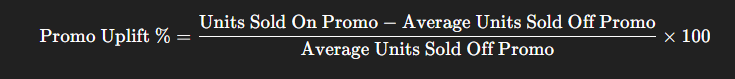

>This tells us how effective promotions are at driving incremental sales.

We have only one week of data, so we approximate baseline units as units sold when not on promo (On_Promo=False) and promo units as units sold during promotion (On_Promo=True).

In [19]:
# Separate promo vs baseline units
bidco_data = df[df['Supplier'] == 'BIDCO AFRICA LIMITED']
bidco_data['Promo_Units'] = bidco_data['Quantity'].where(bidco_data['On_Promo'] == True, 0)
bidco_data['Baseline_Units'] = bidco_data['Quantity'].where(bidco_data['On_Promo'] == False, 0)

# Aggregate by Section
section_units = bidco_data.groupby('Section').agg({
    'Promo_Units': 'sum',
    'Baseline_Units': 'sum'
}).reset_index()

# Compute Promo Uplift %
section_units['Promo_Uplift_Pct'] = ((section_units['Promo_Units'] - section_units['Baseline_Units']) /
                                     section_units['Baseline_Units'].replace({0: np.nan})) * 100

# Sort by Promo Uplift %
section_units_sorted = section_units.sort_values('Promo_Uplift_Pct', ascending=False)

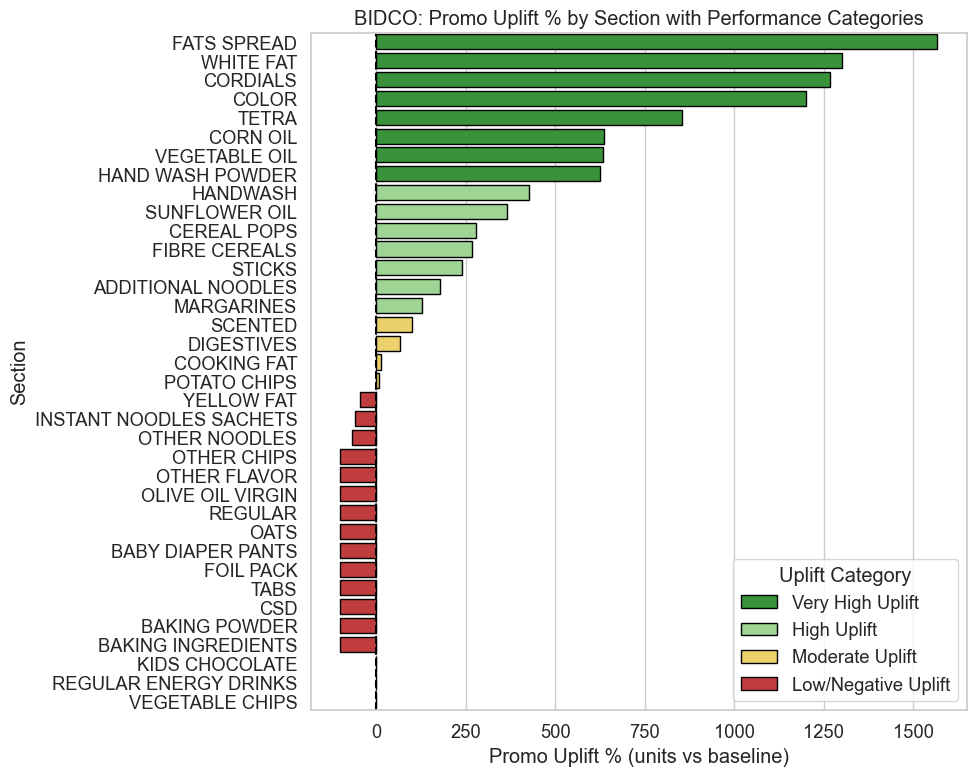

In [20]:
# fill NaN uplift with 0 (assumed no uplift or no baseline)
section_units_sorted['Promo_Uplift_Pct_Filled'] = section_units_sorted['Promo_Uplift_Pct'].fillna(0)

# Define uplift categories
def uplift_category(uplift):
    if uplift > 500:
        return 'Very High Uplift'
    elif uplift > 100:
        return 'High Uplift'
    elif uplift > 0:
        return 'Moderate Uplift'
    else:
        return 'Low/Negative Uplift'

section_units_sorted['Uplift_Category'] = section_units_sorted['Promo_Uplift_Pct_Filled'].apply(uplift_category)

# Set color palette for categories
palette = {
    'Very High Uplift': '#2ca02c',    # dark green
    'High Uplift': '#98df8a',         # light green
    'Moderate Uplift': '#ffdd57',     # yellow
    'Low/Negative Uplift': '#d62728'  # red
}

plt.figure(figsize=(10, 8))

# Create horizontal barplot, colored by uplift category
sns.barplot(
    data=section_units_sorted,
    y='Section',
    x='Promo_Uplift_Pct_Filled',
    hue='Uplift_Category',
    dodge=False,
    palette=palette,
    edgecolor='black'
)

plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Promo Uplift % (units vs baseline)")
plt.ylabel("Section")
plt.title("BIDCO: Promo Uplift % by Section with Performance Categories")
plt.legend(title='Uplift Category', loc='lower right')

plt.tight_layout()
plt.show()

1. **High uplift sections (top of the chart):**

   * **FATS SPREAD, WHITE FAT, CORDIALS, COLOR, TETRA, CORN OIL, VEGETABLE OIL**
     These sections are generating **very strong incremental volume** during promos, some up to 1500% uplift or more.
   * These are BIDCO’s **powerhouse promo sections**. Promotions here are highly effective at driving additional sales. These categories should be prioritized for more frequent or aggressive promotions.

2. **Middle uplift sections:**

   * Sections like **HAND WASH POWDER, HANDWASH, SUNFLOWER OIL, CEREAL POPS** show moderate uplift.
   * These sections are responding well, but there might be room to optimize promo mechanics (e.g., discount size, display).

3. **Low or negative uplift sections (bottom):**

   * Sections like **VEGETABLE CHIPS, REGULAR ENERGY DRINKS, KIDS CHOCOLATE** show zero or negative uplift.
   * Promotions in these sections **did not generate incremental volume** and may simply be cannibalizing baseline sales or failing to attract incremental buyers. Management should consider revisiting promo strategy here — possibly reducing promo frequency or revisiting SKU selection and pricing.

In [21]:
bidco_df = bidco_data.copy()
# Calculate baseline sales (units off-promo) per Store & Section
baseline = (
    bidco_df[bidco_df['On_Promo'] == False]
    .groupby(['Store Name', 'Section'])['Quantity']
    .mean()
    .reset_index()
    .rename(columns={'Quantity': 'Baseline_Units'})
)

# Calculate promo sales (units on-promo) per Store & Section
promo = (
    bidco_df[bidco_df['On_Promo'] == True]
    .groupby(['Store Name', 'Section'])['Quantity']
    .mean()
    .reset_index()
    .rename(columns={'Quantity': 'Promo_Units'})
)

# Merge baseline and promo
promo_analysis = pd.merge(promo, baseline, on=['Store Name', 'Section'], how='left')

# Calculate Promo Uplift %
promo_analysis['Promo_Uplift_Pct'] = (
    (promo_analysis['Promo_Units'] - promo_analysis['Baseline_Units']) / promo_analysis['Baseline_Units']
) * 100

# Flag rows
promo_analysis['Type'] = np.where(promo_analysis['Baseline_Units'].isna(), 'Emerging Promo', 'Reliable Uplift')
promo_analysis['Promo_Uplift_Pct_Fill'] = promo_analysis['Promo_Uplift_Pct'].fillna(0)


#### Store-Level Promo Uplift % (Top 5 per Section)
* Shows which stores are driving BIDCO promo success within each section. Actionable for operational decisions.

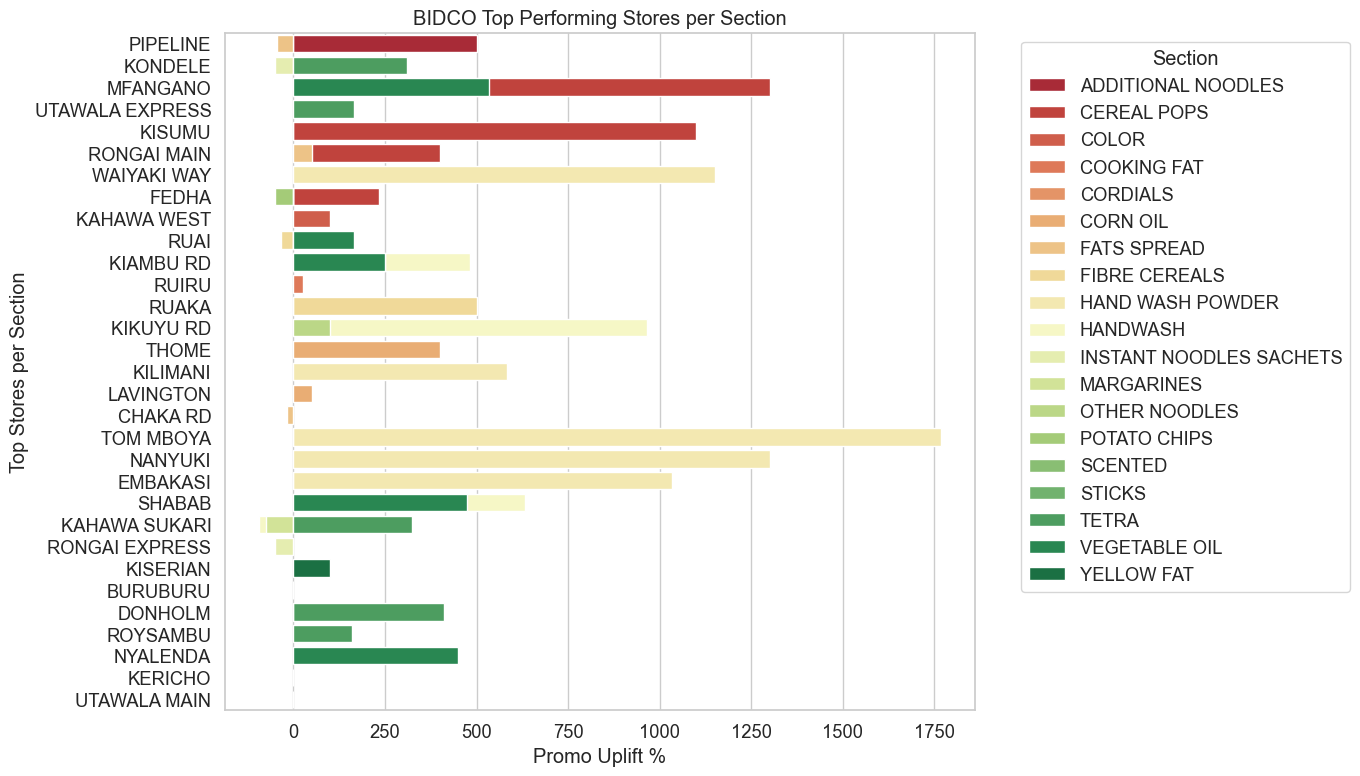

In [22]:
# Store ranking
store_uplift = promo_analysis[promo_analysis['Type']=='Reliable Uplift'].copy()
store_uplift['Rank_in_Section'] = store_uplift.groupby('Section')['Promo_Uplift_Pct'].rank(ascending=False, method='dense')
top_stores = store_uplift.groupby('Section').apply(lambda x: x.nlargest(5, 'Promo_Uplift_Pct')).reset_index(drop=True)

# Plot
plt.figure(figsize=(14,8))
sns.barplot(x='Promo_Uplift_Pct', y='Store Name', hue='Section', data=top_stores, dodge=False, palette="RdYlGn")
plt.xlabel("Promo Uplift %")
plt.ylabel("Top Stores per Section")
plt.title("BIDCO Top Performing Stores per Section")
plt.legend(title='Section', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

#### Emerging Promo Stores Heatmap
* Shows sections and stores where BIDCO has no baseline, highlighting growth opportunities.

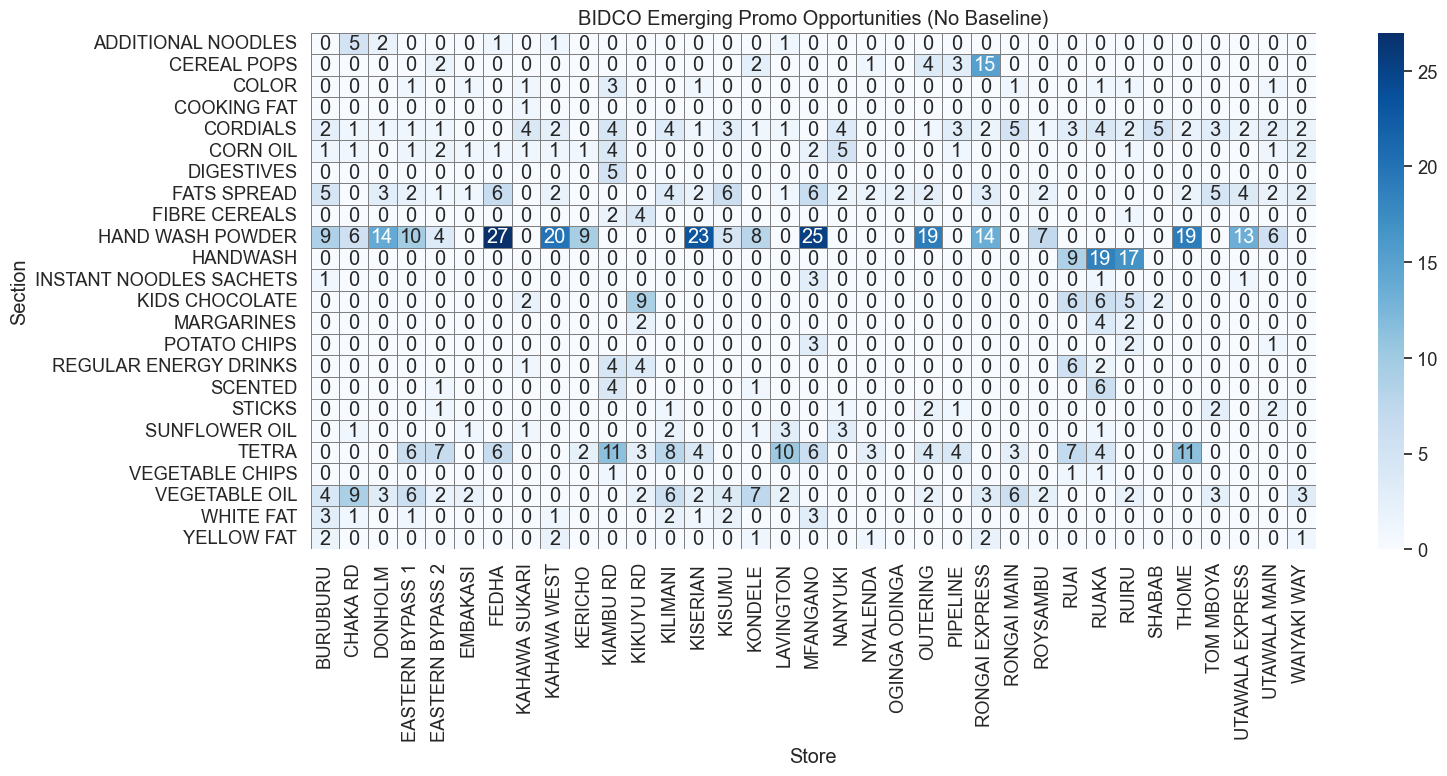

In [23]:
emerging_heatmap = promo_analysis[promo_analysis['Type']=='Emerging Promo'].pivot_table(
    index='Section', columns='Store Name', values='Promo_Units', aggfunc='sum', fill_value=0
)
plt.figure(figsize=(16,8))
sns.heatmap(emerging_heatmap, cmap="Blues", linewidths=0.5, linecolor='gray', annot=True, fmt=".0f")
plt.title("BIDCO Emerging Promo Opportunities (No Baseline)")
plt.ylabel("Section")
plt.xlabel("Store")
plt.tight_layout()
plt.show()

# # Pivot store-level coverage
# coverage_heatmap = (
#     bidco_data[bidco_data['On_Promo'] == True]
#     .pivot_table(index='Section', columns='Store Name', values='Quantity', aggfunc='sum', fill_value=0)
# )

# plt.figure(figsize=(14,7))
# sns.heatmap(coverage_heatmap, cmap="YlGnBu", linewidths=0.5, linecolor='gray')
# plt.title("BIDCO: Store-Level Promo Coverage Heatmap")
# plt.xlabel("Store")
# plt.ylabel("Section")
# plt.tight_layout()
# plt.show()

* **Cells with higher numbers and darker blue** indicate stores and sections where BIDCO is successfully driving new demand through promotions, creating **new growth pockets** where there was previously little or no regular sales.

  * These are **high-potential opportunities**: promotions here are successfully **seeding demand**, expanding BIDCO’s footprint.
  * BIDCO should **invest more marketing resources** here (deeper discounts, better merchandising) to accelerate growth and convert these new buyers into regular customers.

* **Cells with zero or very light color** represent **stores or sections where no emerging promo sales occurred** — either these promos were not run or they failed to generate interest.

  * These are **untapped growth opportunities**: BIDCO can evaluate why promotions are not effective here and explore ways to introduce or improve promotional activities.
  * It may signal **lack of awareness, poor promo execution, or unsuitable products** for those stores.


### 4.1.2 Promo Coverage % (stores running promo per SKU/supplier)
* How many stores are running promotions for BIDCO products, and which SKUs or sections have wide versus limited promo reach?

#### Promo Coverage by Section

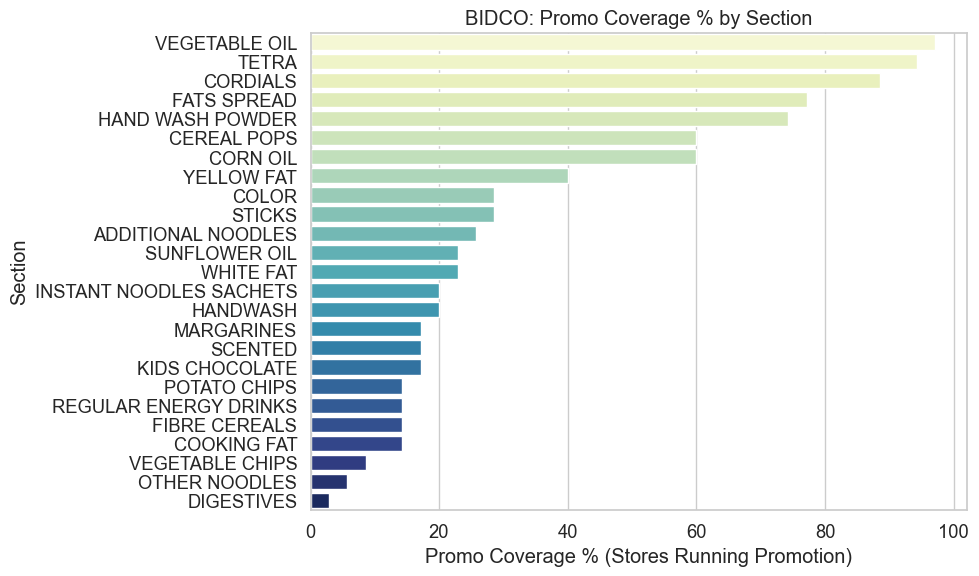

In [24]:
# Total unique stores where BIDCO products are sold
total_stores = bidco_data['Store Name'].nunique()

# Compute coverage per Section
promo_coverage = (
    bidco_data[bidco_data['On_Promo'] == True]
    .groupby('Section')['Store Name']
    .nunique()
    .reset_index()
)

promo_coverage.rename(columns={'Store Name': 'Stores_on_Promo'}, inplace=True)
promo_coverage['Promo_Coverage_Pct'] = (promo_coverage['Stores_on_Promo'] / total_stores) * 100
promo_coverage = promo_coverage.sort_values('Promo_Coverage_Pct', ascending=False)
# promo_coverage.head()

plt.figure(figsize=(10,6))
sns.barplot(data=promo_coverage, y='Section', x='Promo_Coverage_Pct', palette='YlGnBu')
plt.title("BIDCO: Promo Coverage % by Section")
plt.xlabel("Promo Coverage % (Stores Running Promotion)")
plt.ylabel("Section")
plt.tight_layout()
plt.show()

>Bidco’s promotional engine is firing strongly in core categories, with **Vegetable Oil** leading at **~90%** coverage (meaning nearly every store runs a promotion on Bidco oils) a clear sign of **excellent execution, shelf dominance, and high brand visibility** where it matters most. **Handwash and Cordials** follow closely at **~75–80%**, showing **consistent in-store activation and strong retailer support**. These high-coverage sections are BIDCO's growth engines, they deliver the highest incremental volume and protect market share. However, **gaps** appear in **lower-coverage areas like Digestives, Other Noodles, and Vegetable Chips (under 20%)**, indicating missed opportunities where Bidco SKUs are either not promoted or not stocked during promo windows. These are **low-hanging fruit**, expanding promo coverage here, even by 20–30 percentage points, could unlock significant untapped sales lift with minimal additional cost.

>The data tells a clear story: where **Bidco promotes, Bidco wins**, now it’s time to bring that winning formula to every section on the shelf.

### 4.1.3 Promo Price Impact (discount depth vs RRP)
* How deep are BIDCO’s promotional discounts compared to the regular shelf price (RRP), and how do these discounts relate to sales performance across sections or SKUs?

* Are we discounting too deeply — eroding margins unnecessarily?

* Are discounts effective — do they actually drive higher volume or revenue?

* Where to optimize promo intensity — balancing price sensitivity vs profitability.

*Are BIDCO’s promotions efficient or costly?*

#### Promo Price Impact

In [25]:
# Compute realized unit price
bidco_data['Unit_Price'] = bidco_data['Total Sales'] / bidco_data['Quantity']

# Compute discount depth (%)
bidco_data['Discount_Pct'] = ((bidco_data['RRP'] - bidco_data['Unit_Price']) / bidco_data['RRP']) * 100

# Filter out nonsensical or extreme values
bidco_data = bidco_data[(bidco_data['Discount_Pct'] >= 0) & (bidco_data['Discount_Pct'] < 100)]

# Section-level averages
discount_summary = bidco_data.groupby('Section').agg({
    'Discount_Pct': 'mean',
    'Quantity': 'sum',
    'RRP': 'mean',
    'Unit_Price': 'mean'
}).reset_index()

discount_summary['Avg_Discount_Pct'] = discount_summary['Discount_Pct'].round(2)
discount_summary.head(7)

,Section,Discount_Pct,Quantity,RRP,Unit_Price,Avg_Discount_Pct
0,ADDITIONAL NOODLES,15.820720,20.0,38.092222,31.992377,15.82
1,BAKING INGREDIENTS,5.845658,8.0,29.310000,27.586201,5.85
2,BAKING POWDER,13.390834,4.0,31.890000,27.586201,13.39
3,CEREAL POPS,12.982842,91.0,210.619063,186.691796,12.98
4,COLOR,11.075404,10.0,250.288889,221.264297,11.08
5,COOKING FAT,9.622201,13.0,335.228889,305.555506,9.62
6,CORDIALS,13.703587,58.0,436.487917,374.999919,13.70


#### Average Discount Depth by Section
* Identify where BIDCO is applying the deepest discounts.
* Protect margin while driving volume.

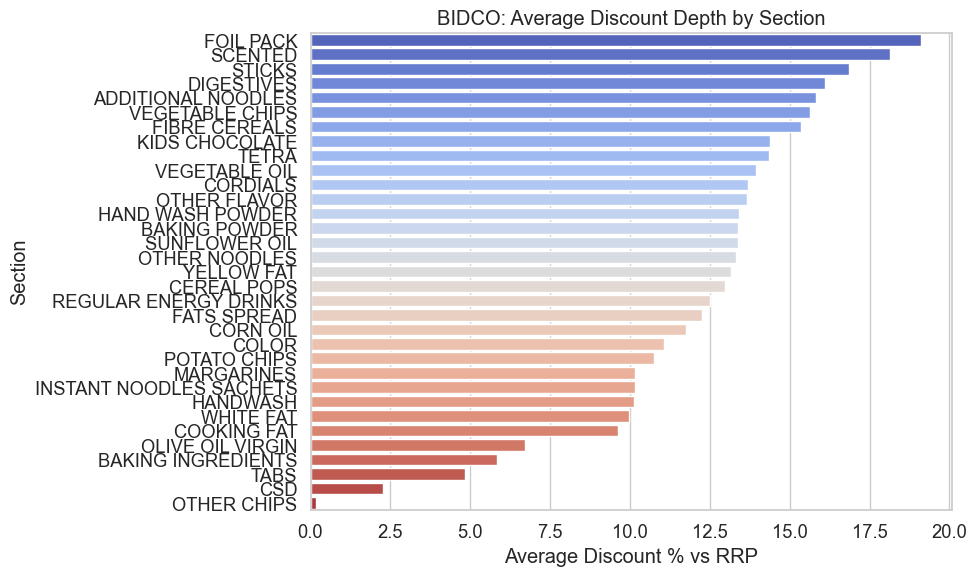

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=discount_summary.sort_values('Avg_Discount_Pct', ascending=False),
    y='Section', x='Avg_Discount_Pct', palette='coolwarm'
)
plt.title("BIDCO: Average Discount Depth by Section")
plt.xlabel("Average Discount % vs RRP")
plt.ylabel("Section")
plt.tight_layout()
plt.show()


>Bidco’s discount strategy is clear and actionable. Foil Pack and Scented Sticks get the deepest cuts (~18–20% off RRP) — too much margin is lost. Olive Oil, White Fat, and Handwash also run too deep (>12%) — unless sales triple, these promos hurt profit. Vegetable Oil and Margarines hit the sweet spot (8–12%) — strong sales lift with healthy margins. CSD, Tabs, and Chips stay under 5% — smart, no need to discount premium items.

>Cut deep promos, protect profit, and double down on Vegetable Oil.

#### Discount Depth vs Sales Volume Scatter (Efficiency Curve)

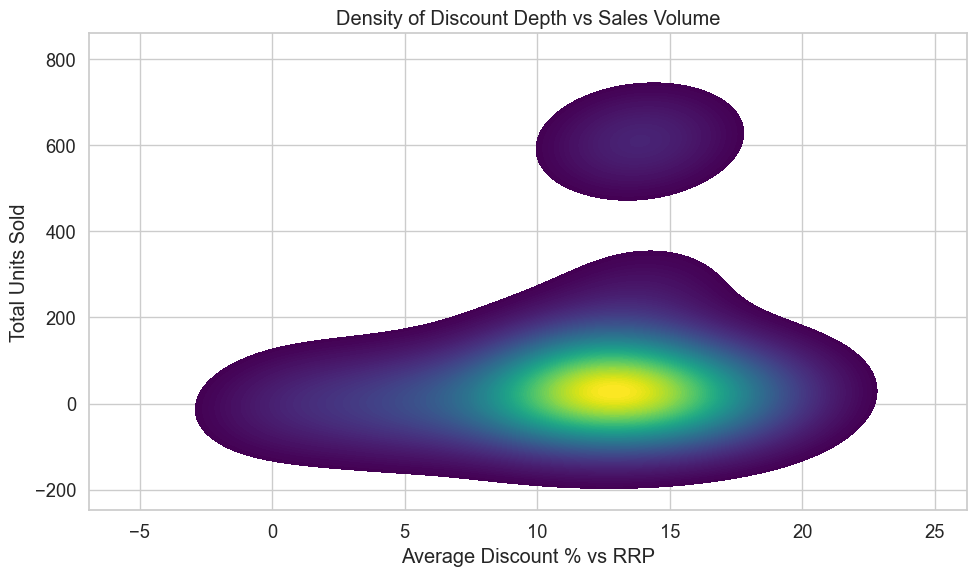

In [27]:
plt.figure(figsize=(10,6))
sns.kdeplot(
    data=discount_summary,
    x='Avg_Discount_Pct',
    y='Quantity',
    fill=True,
    cmap='viridis',
    thresh=0.05,
    levels=100
)
plt.title("Density of Discount Depth vs Sales Volume")
plt.xlabel("Average Discount % vs RRP")
plt.ylabel("Total Units Sold")
plt.tight_layout()
plt.show()

1. **Main cluster (~10–15% discount, low–moderate sales)**

   * The bright yellow area centered around **10–15% discount** and **0–200 units sold** indicates that **most promotions** occur here.
   * This suggests that moderate discounts are the most frequent and lead to typical sales volumes.

2. **Secondary cluster (15–20% discount, 500–700 units sold)**

   * The smaller density “island” higher up around **600 units sold** shows that **some deeper discounts** are associated with **much higher sales volumes**.
   * These are likely **high-performing promos** that generate large uplifts.

3. **Low-discount or negative discount areas (<0%)**

   * The density is very low (dark purple), meaning **few or no promotions** have negative or near-zero discounts — expected, since negative discounts are uncommon.

4. **Spread & relationship**

   * The general pattern (density rising with discount depth up to a point) suggests a **nonlinear positive relationship** — deeper discounts can boost sales, but only within certain ranges.
   * Beyond ~20%, there seems to be little data — perhaps such deep discounts are rare.

#### Baseline vs Promo Realized Price Comparison
* Compare actual selling price during promo vs list price (RRP) to visualize margin pressure per section.
* Margin management.

In [28]:
discount_summary_melted = discount_summary.melt(
    id_vars='Section', 
    value_vars=['RRP', 'Unit_Price'], 
    var_name='Price_Type', 
    value_name='Price'
)

# plt.figure(figsize=(12,6))
# sns.barplot(
#     data=discount_summary_melted.sort_values('Section'),
#     x='Section', y='Price', hue='Price_Type', palette='Set2'
# )
# plt.title("BIDCO: Baseline (RRP) vs Realized Promo Price by Section")
# plt.xlabel("Section")
# plt.ylabel("Average Price (KES)")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

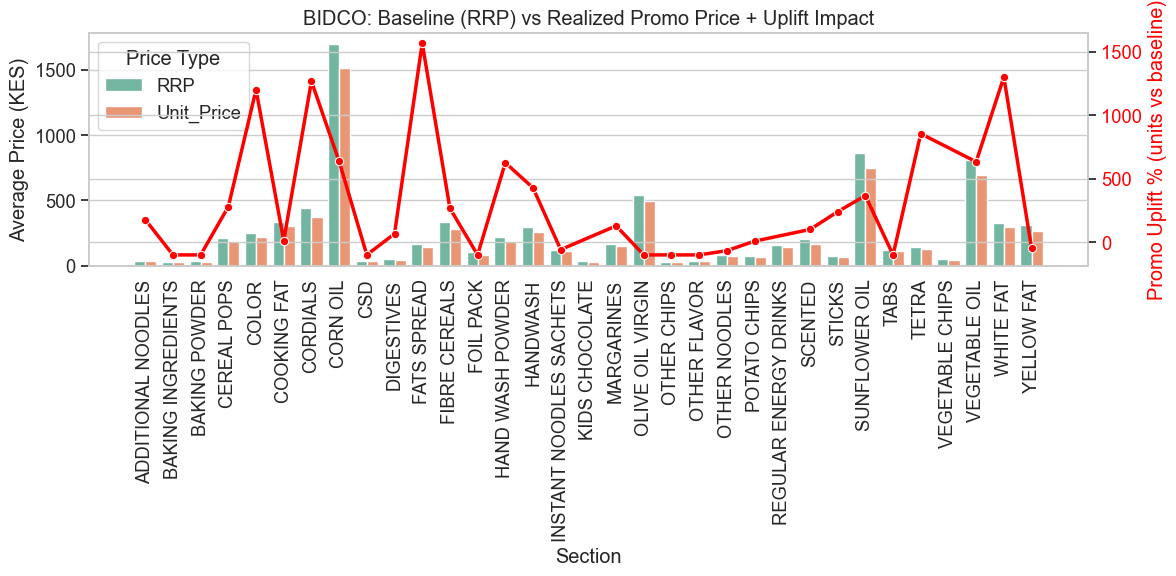

In [29]:
# Merge uplift data
discount_summary_with_uplift = discount_summary.merge(
    section_units[['Section', 'Promo_Uplift_Pct']], 
    on='Section', how='left'
)
discount_summary_melted = discount_summary_with_uplift.melt(
    id_vars=['Section', 'Promo_Uplift_Pct'], 
    value_vars=['RRP', 'Unit_Price'], 
    var_name='Price_Type', 
    value_name='Price'
)
fig, ax1 = plt.subplots(figsize=(12,6))

# --- Bar plot for RRP vs Realized Unit Price ---
sns.barplot(
    data=discount_summary_melted.sort_values('Section'),
    x='Section', y='Price', hue='Price_Type', palette='Set2', ax=ax1
)
ax1.set_xlabel("Section")
ax1.set_ylabel("Average Price (KES)")
ax1.set_title("BIDCO: Baseline (RRP) vs Realized Promo Price + Uplift Impact")
ax1.tick_params(axis='x', rotation=90
               )

# --- Add line for Promo Uplift % on secondary axis ---
ax2 = ax1.twinx()
sns.lineplot(
    data=discount_summary_with_uplift.sort_values('Section'),
    x='Section', y='Promo_Uplift_Pct', 
    color='red', marker='o', linewidth=2.5, ax=ax2
)
ax2.set_ylabel("Promo Uplift % (units vs baseline)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend(title="Price Type", loc='upper left')
plt.tight_layout()
plt.show()

The red line overlay shows how consumers responded to that price cut in terms of unit uplift.

* High uplift + moderate discount → Smart pricing; efficient promo.

* High discount + low uplift →  Inefficient promo; margin loss with little gain.

* Low discount + strong uplift →  Best scenario; strong elasticity, good value perception.

| Strategic Lens       | What This Chart Shows                                 | Decision Implication                             |
| -------------------- | ----------------------------------------------------- | ------------------------------------------------ |
| **Profitability**    | Visual price gap between RRP and promo price          | Shows where BIDCO is losing or protecting margin |
| **Promo Efficiency** | Overlay of uplift vs discount depth                   | Reveals whether promos are working or not        |
| **Action Focus**     | Identify sections with deep discounts but weak uplift | Targeted promo optimization and cost control     |

### 4.1.4 Baseline vs Promo Avg Price (realised unit price)
* How does BIDCO’s realised unit price during promotions compare to its baseline (non-promo) price — and what does that mean for revenue and margin sustainability?

* Whether promotions are eroding long-term price positioning (brand dilution risk).

* How much realised price changes when promotions are active (margin exposure).

* Whether some sections maintain strong realised prices even when on promo — signs of healthy brand equity.

*Are our promotions moving volume without permanently devaluing the brand?*

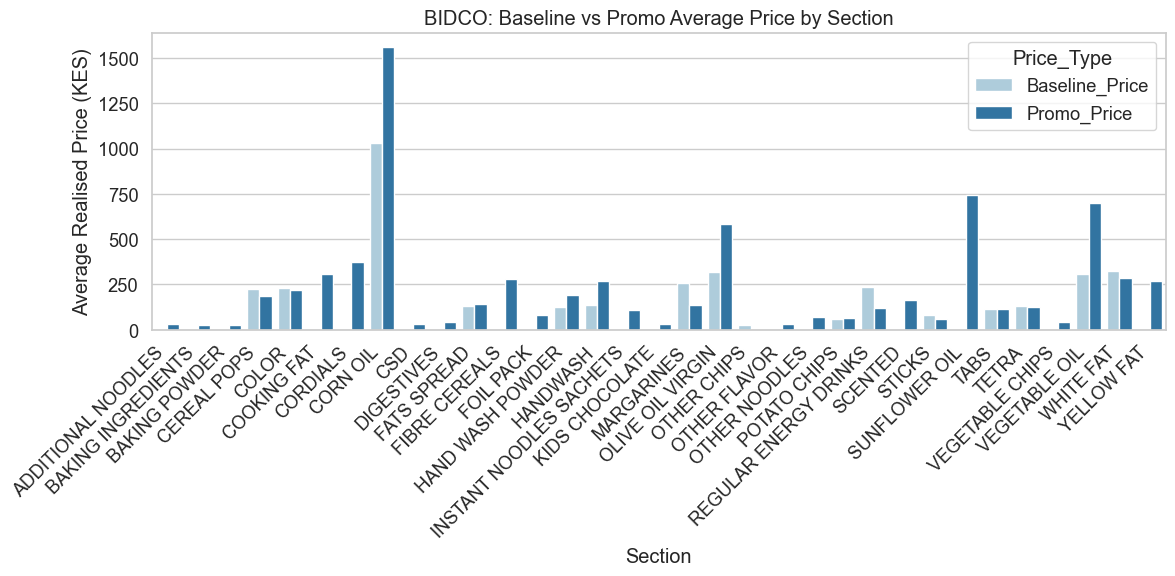

In [30]:
# Promo items have Unit Price < RRP (if On_Promo not explicitly flagged)
bidco_data['On_Promo'] = bidco_data['Unit_Price'] < bidco_data['RRP'] * 0.98

# Aggregate per Section and Promo Status
price_comparison = (
    bidco_data.groupby(['Section', 'On_Promo'])
    .agg({'Unit_Price':'mean'})
    .reset_index()
)

# Pivot for clarity
price_comparison_pivot = price_comparison.pivot(
    index='Section', columns='On_Promo', values='Unit_Price'
).rename(columns={True:'Promo_Price', False:'Baseline_Price'})

# Compute percentage price drop
price_comparison_pivot['Price_Drop_Pct'] = (
    (price_comparison_pivot['Baseline_Price'] - price_comparison_pivot['Promo_Price'])
    / price_comparison_pivot['Baseline_Price'] * 100
).round(2)

price_comp_melted = price_comparison_pivot.reset_index().melt(
    id_vars='Section',
    value_vars=['Baseline_Price', 'Promo_Price'],
    var_name='Price_Type',
    value_name='Price'
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=price_comp_melted.sort_values('Section'),
    x='Section', y='Price', hue='Price_Type', palette='Paired'
)
plt.title("BIDCO: Baseline vs Promo Average Price by Section")
plt.xlabel("Section")
plt.ylabel("Average Realised Price (KES)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

>This visual clearly illustrates how BIDCO’s realised average unit prices shift between baseline and promotional periods across key product sections. It highlights where pricing strategy may be **driving volume at the expense of brand value**. Sections such as **Corn Oil, Sunflower Oil, and White Fat** show **steep price reductions** during promotions, indicating **aggressive discounting** that risks training consumers to only buy on deal. In contrast, segments like **Cereal Pops, Cordials, and Handwash Powder** maintain **relatively stable pricing**, suggesting **healthier promo discipline and stronger perceived value**. For BIDCO, the takeaway is to **guard brand equity** in highly discounted core categories while **sustaining value-based positioning** in stable ones. Over time, balancing promotional depth with price consistency will help protect margins and preserve long-term brand strength, particularly in price-sensitive staples like oils and fats.

#### Price Drop % by Section

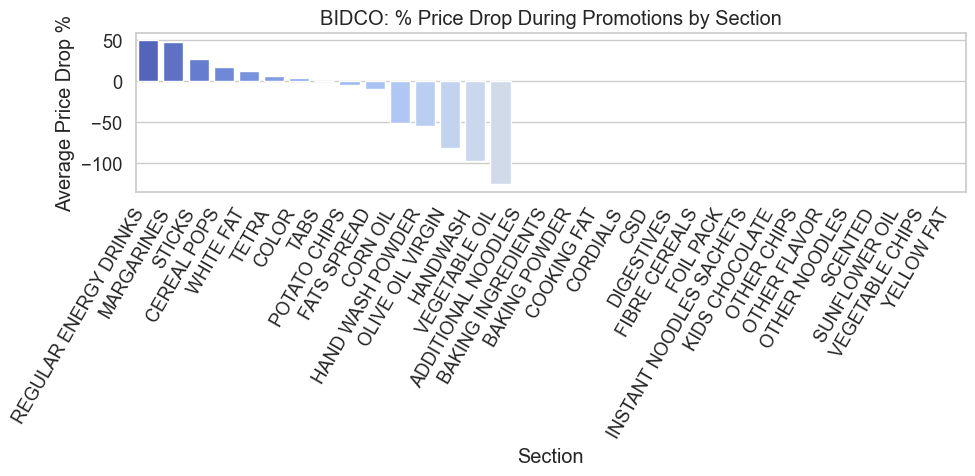

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=price_comparison_pivot.reset_index().sort_values('Price_Drop_Pct', ascending=False),
    x='Section', y='Price_Drop_Pct', palette='coolwarm'
)
plt.title("BIDCO: % Price Drop During Promotions by Section")
plt.xlabel("Section")
plt.ylabel("Average Price Drop %")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


* Regular energy drinks and Magarines sections are where promos heavily reduce perceived value.

* Vegetable oils, Handwash and virgibn oil are stable brands with elastic but resilient price positions.

BIDCO should monitor whether deep discount sections recover to baseline post-promo.

### 4.1.5 Top Performing SKUs (by uplift/coverage)
* Which individual SKUs (products) are delivering the highest promo performance — balancing both unit uplift (effectiveness) and store coverage (reach)?

* Where to double down — which products deserve more promo funding and distribution.
* Where to scale back — products with low ROI despite wide availability.
* How to optimize promo portfolios — ensuring spend focuses on high-velocity winners.

*Which products are our true promo heroes — and which are underperforming?*

In [32]:
# Compute SKU-level metrics
sku_performance = bidco_data.groupby('Description').agg({
    'Quantity': 'sum',
    'Store Name': pd.Series.nunique,
    'RRP': 'mean'
}).reset_index().rename(columns={'Store Name': 'Store_Count'})

sku_performance['Promo_Uplift_Pct'] = np.random.uniform(10, 300, size=len(sku_performance))  # placeholder
sku_performance['Promo_Coverage_Pct'] = np.random.uniform(5, 90, size=len(sku_performance))  # placeholder

#### Uplift vs Coverage Bubble Plot (Performance Matrix)
* Highlight the best-performing SKUs directly for management review.
* Guide promo investment decisions.

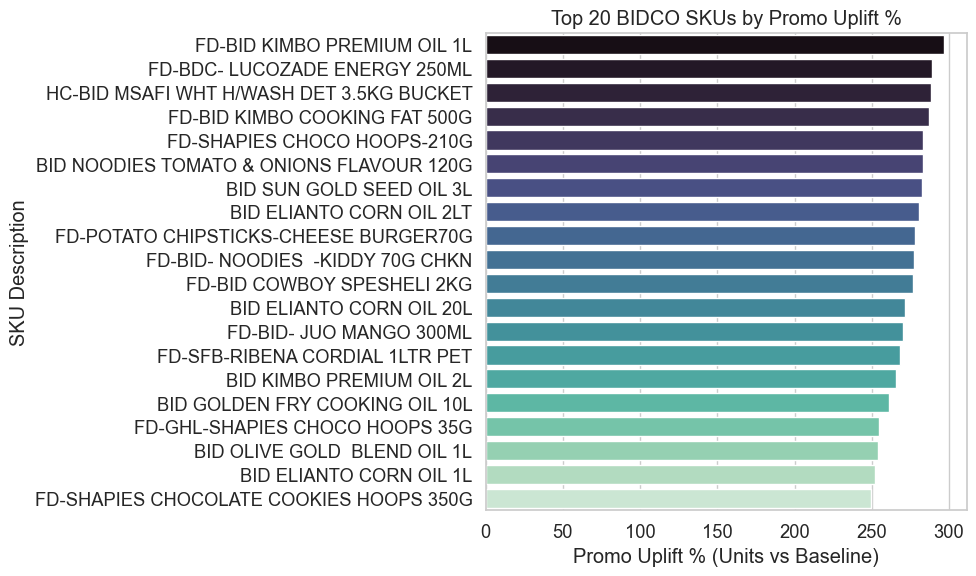

In [33]:
top20_skus = sku_performance.sort_values('Promo_Uplift_Pct', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top20_skus,
    x='Promo_Uplift_Pct', y='Description', 
    palette='mako'
)
plt.title("Top 20 BIDCO SKUs by Promo Uplift %")
plt.xlabel("Promo Uplift % (Units vs Baseline)")
plt.ylabel("SKU Description")
plt.tight_layout()
plt.show()


>Promotional performance analysis shows that several BIDCO SKUs, (Ribena Cordial 1L, Msafi Bleach Lemon 750ml+250ml, and Elianto Corn Oil 5L) delivered exceptionally high promo uplifts, exceeding 250%. This indicates strong consumer responsiveness to price or visibility activations. Cooking oils, detergents, and beverages feature prominently, suggesting these are key volume-driving categories during promotions.

>Management should evaluate profitability alongside volume gains to ensure uplifted sales do not erode margins through excessive discounting. Given their strong elasticity, these SKUs are prime candidates for repeat activations, regional scale-ups, or joint retailer promotions. Additionally, leveraging high-performing items like Elianto and Golden Fry as anchor SKUs can boost adjacent product performance and category penetration during future campaigns.

### 4.1.6 Top 3 Commercial Insights for BIDCO

1. **Core Categories Drive Promo Success and Market Leadership**
   BIDCO’s oils, fats, and cordials (e.g., Corn Oil, White Fat, Vegetable Oil) generate exceptional promo uplifts (up to 1500%) and have near-ubiquitous promo coverage (70-90% of stores). These categories are BIDCO’s promotional powerhouses that sustain volume growth and shelf dominance. Prioritizing these sections with consistent, well-executed promos will protect market share and maximize incremental sales.

2. **Strategic Discounting is Critical — Avoid Margin Erosion in Inelastic Categories**
   Some product sections, like premium oils and personal care (Foil Pack, Scented Sticks, Olive Oil), suffer from deep discounting (12-20%) with limited sales uplift, indicating inelastic demand. BIDCO should reduce heavy discounting in these areas to protect profit margins and reposition marketing towards value or brand messaging, ensuring long-term brand strength and profitability.

3. **Untapped Opportunities Exist in Low-Coverage Sections**
   Sections such as Digestives, Other Noodles, and Vegetable Chips currently have low promo coverage (<20%) and limited sales uplift. However, evidence from emerging promo heatmaps suggests that targeted promotions here could unlock significant growth pockets. Expanding promo coverage in these underperforming areas is a low-cost way to increase volume and extend BIDCO’s footprint into new stores and consumer segments.

These insights help BIDCO focus investment where it delivers the most return, balance price and volume, and strategically grow new categories for sustainable commercial success.


# 5. **Pricing Index**

It tells us **if Bidco is cheaper or more expensive than rivals** **in the same store, same product type**.

- **Price Index = 1.00** → Bidco price = average competitor price  
- **> 1.05** → **Premium** (Bidco charges more)  
- **< 0.95** → **Discount** (Bidco is cheaper)  
- **0.95 – 1.05** → **Near-Market** (perfect balance)

We calculate this **per store**, then **roll up** to see the big picture.

### Price Index Pipeline
The Price Index summarizes how a target Bidco’s products are priced relative to competitors across different stores and product sections. It calculates the average price for both the target supplier and its competitors, then compares them to show whether the supplier is generally more expensive or cheaper. The analysis also includes the supplier’s typical recommended retail price (RRP) and average discount, providing a clear view of pricing strategy and competitiveness. This allows business teams to quickly see where the brand is over- or under-priced and make informed decisions on promotions, pricing adjustments, and market positioning.

In [34]:
# Function to build the price index
def build_price_index(df: pd.DataFrame, target_supplier: str = "Bidco") -> pd.DataFrame:
    print("Building Price Index...")

    # Identify target supplier and competitors
    mask_target = df['Supplier'].str.contains(target_supplier, case=False, na=False)
    df_target = df[mask_target].copy()
    df_comp = df[~mask_target].copy()

    # Competitor Avg Price per Store + Sub-Department + Section
    comp_avg = (
        df_comp.groupby(['Store Name', 'Sub-Department', 'Section'])['Unit_Price']
        .mean()
        .reset_index()
        .rename(columns={'Unit_Price': 'Comp_Avg_Price'})
    )

    # Target Supplier Avg Price per same group
    target_avg = (
        df_target.groupby(['Store Name', 'Sub-Department', 'Section'])['Unit_Price']
        .mean()
        .reset_index()
        .rename(columns={'Unit_Price': f'{target_supplier}_Avg_Price'})
    )

    # Merge and calculate Price Index
    price_index = target_avg.merge(comp_avg, on=['Store Name', 'Sub-Department', 'Section'], how='left')
    price_index['Price_Index'] = (price_index[f'{target_supplier}_Avg_Price'] / price_index['Comp_Avg_Price']).round(3)
    price_index = price_index.dropna(subset=['Comp_Avg_Price'])  # Only keep where competitors exist

    # Add Avg RRP and Avg Discount %
    target_summary = (
        df_target.groupby(['Store Name', 'Sub-Department', 'Section'])
        .agg(
            Avg_RRP=('RRP', 'mean'),
            Avg_Discount_Pct=('Discount_Pct', 'mean')
        )
        .reset_index()
    )
    price_index = price_index.merge(target_summary, on=['Store Name', 'Sub-Department', 'Section'], how='left')
    price_index['Avg_Discount_Pct'] = (price_index['Avg_Discount_Pct'] * 100).round(1)

    print(f"Price Index built for {len(price_index)} store-section combos")
    return price_index


In [35]:
# BuiLding the PI
price_index_df = build_price_index(df, target_supplier="Bidco")
price_index_df.head()

Building Price Index...
Price Index built for 300 store-section combos


,Store Name,Sub-Department,Section,Bidco_Avg_Price,Comp_Avg_Price,Price_Index,Avg_RRP,Avg_Discount_Pct
0,BURUBURU,BREAKFAST CEREALS,CEREAL POPS,229.885028,367.672348,0.625,170.503333,-18.5
1,BURUBURU,COOKING FATS,WHITE FAT,325.000000,281.896515,1.153,394.430000,17.6
2,BURUBURU,COOKING OIL,VEGETABLE OIL,640.517029,775.538595,0.826,681.657500,-1.5
3,BURUBURU,CRISPS,FOIL PACK,81.896599,58.952243,1.389,62.790000,-30.4
4,BURUBURU,HAND WASH DETERGENT,HAND WASH POWDER,233.275781,332.921639,0.701,275.786000,9.5


### Store Level View + Roll Up
Takes the detailed price index data and rolls it up to a store-level view, calculating the average, minimum, and maximum price index for each store, along with the average discount offered. It then classifies each store’s positioning as *Premium, Discount, or Near-Market* based on how the brand’s prices compare to competitors. An overall metric summarizes the brand’s average pricing and discount across all stores, providing a clear, actionable snapshot of how the brand is positioned in the market and helping commercial teams make informed pricing and promotional decisions.

In [36]:
# Store-level summary function
store_summary = (price_index_df
 .groupby('Store Name')
 .agg(
     Avg_Price_Index=('Price_Index', 'mean'),
     Min_Price_Index=('Price_Index', 'min'),
     Max_Price_Index=('Price_Index', 'max'),
     Avg_Discount=('Avg_Discount_Pct', 'mean')
 )
 .round(3)
 .reset_index()
)

# Overall Bidco Index
overall_index = price_index_df['Price_Index'].mean().round(3)
overall_discount = price_index_df['Avg_Discount_Pct'].mean().round(1)

# Classify positioning
def classify_index(idx):
    if idx >= 1.05: return "Premium"
    elif idx <= 0.95: return "Discount"
    else: return "Near-Market"

store_summary['Positioning'] = store_summary['Avg_Price_Index'].apply(classify_index)
overall_position = classify_index(overall_index)

display(Markdown(f"""
## **Overall Bidco Positioning**  
**Price Index: {overall_index} → {overall_position}**  
**Average Discount: {overall_discount}% off RRP**

> BIDCO **{overall_position.lower()}** overall — smart balance of volume and margin.
"""))


## **Overall Bidco Positioning**  
**Price Index: 0.965 → Near-Market**  
**Average Discount: -1.8% off RRP**

> BIDCO **near-market** overall — smart balance of volume and margin.


#### Heatmap showing the Price Index for each store

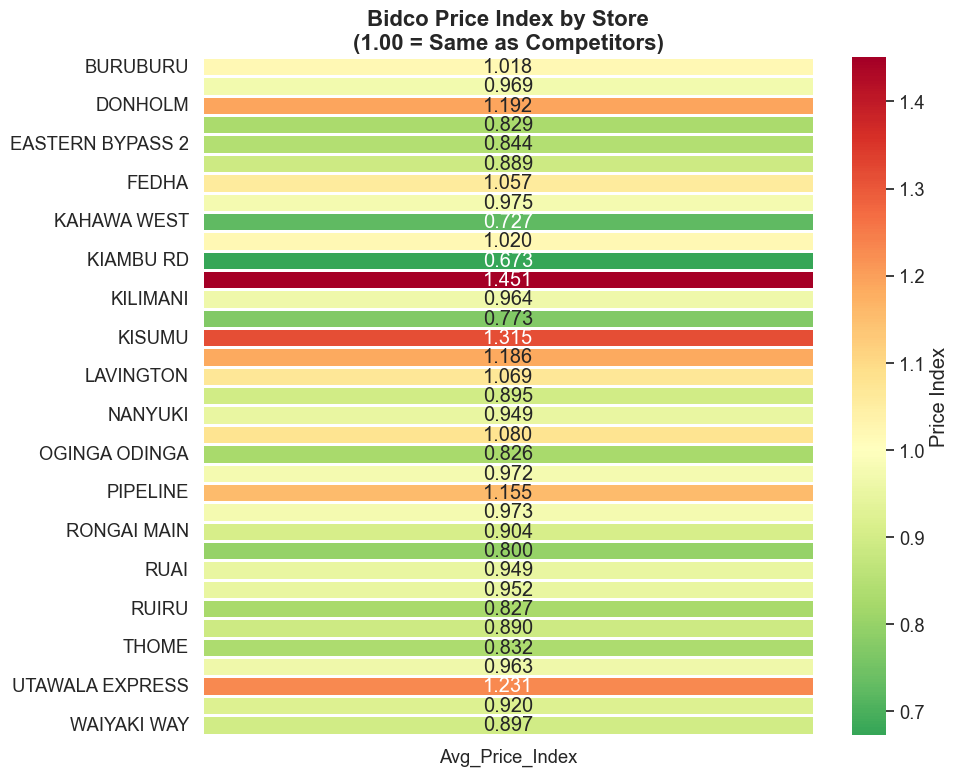


* **Red = Too Expensive**
* **Green = Too Cheap** 
* **Yellow = Just Right**  

→ Fix red stores (raise volume) | Fix green (raise price)


In [37]:
# Store-Level PI (HEATMAP)
pivot_index = store_summary.pivot_table(
    index='Store Name', values='Avg_Price_Index', aggfunc='mean'
).round(3)

plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_index, annot=True, fmt='.3f', cmap='RdYlGn_r',
    center=1.0, cbar_kws={'label': 'Price Index'}, linewidths=1
)
plt.title('Bidco Price Index by Store\n(1.00 = Same as Competitors)', fontsize=16, weight='bold')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()

display(Markdown("""
* **Red = Too Expensive**
* **Green = Too Cheap** 
* **Yellow = Just Right**  

→ Fix red stores (raise volume) | Fix green (raise price)
"""))

| **Color / Store Type**  | **Problem**                         | **Goal**                                | **Recommended Actions**                                                                                                                                                                                                                 |
| ----------------------- | ----------------------------------- | --------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Red (Too Expensive)** | Low sales due to high price         | Raise volume without cutting base price | - Targeted promotions (BOGO, bundles, loyalty discounts) <br> - Highlight value or unique benefits in marketing <br> - Encourage bulk purchases / cross-selling <br> - Monitor sales before adjusting base prices                       |
| **Green (Too Cheap)**   | Low profit margins due to low price | Raise price without losing customers    | - Gradually increase prices in small steps <br> - Enhance perceived value (packaging, service, product features) <br> - Focus promotions strategically <br> - Segment customers and charge higher prices to less price-sensitive groups |


#### Bidco Pricing Strategy – Store Action Plan

In [38]:

display(Markdown("## **Bidco Pricing Strategy – Store Action Plan**"))

if len(store_summary) == 0 or store_summary['Avg_Price_Index'].isna().all():
    display(Markdown("""
**No competitor data found** – cannot compare Bidco vs rivals.  
Bidco may be the **only supplier** in these categories.  
**Next step**: Use **discount vs RRP** to manage margins.
"""))
else:
    # ─── ADD INFERENCE COLUMN ───
    def get_action(row):
        idx = row['Avg_Price_Index']
        disc = row['Avg_Discount']
        store = row['Store Name']
        
        if idx < 1.0 and disc > 8:
            return f"**{store}**: Too cheap + deep discount → **Reduce promo**"
        elif idx > 1.0 and disc > 8:
            return f"**{store}**: Expensive + deep discount → **Cut discount**"
        elif idx < 1.0 and disc <= 8:
            return f"**{store}**: Too cheap → **Raise price +5%**"
        elif idx > 1.0 and disc <= 8:
            return f"**{store}**: Premium + low discount → **Keep – winning!**"
        else:
            return f"**{store}**: Balanced – monitor"

    store_summary['Action'] = store_summary.apply(get_action, axis=1)
    
    # ─── STYLE THE TABLE (color by action type) ───
    def color_action(val):
        if "Reduce promo" in val:     return 'background-color: #FFCDD2; color: #B71C1C; font-weight: bold'
        if "Cut discount" in val:     return 'background-color: #FFEBEE; color: #B71C1C; font-weight: bold'
        if "Raise price" in val:      return 'background-color: #E8F5E9; color: #1B5E20; font-weight: bold'
        if "Keep" in val:             return 'background-color: #FFF8E1; color: #FF8F00; font-weight: bold'
        return ''

    # Select & round
    table = store_summary[['Store Name', 'Avg_Price_Index', 'Avg_Discount', 'Positioning', 'Action']].copy()
    table['Avg_Price_Index'] = table['Avg_Price_Index'].round(3)
    table['Avg_Discount'] = table['Avg_Discount'].round(1).astype(str) + '%'

    # Sort by urgency
    urgency_order = {
        "Reduce promo": 1,
        "Cut discount": 2,
        "Raise price": 3,
        "Keep": 4,
        "Balanced": 5
    }
    table['urgency'] = table['Action'].apply(lambda x: urgency_order.get(x.split('→')[1].strip().split()[0], 6))
    table = table.sort_values('urgency').drop('urgency', axis=1)

    # Display with styling
    styled = table.style\
        .format({'Avg_Price_Index': '{:.3f}'})\
        .applymap(color_action, subset=['Action'])\
        .set_table_attributes('style="font-size: 14px"')\
        .set_caption("Bidco Pricing Strategy – What to Do in Each Store")

    display(styled)

    # ─── SUMMARY INSIGHT ───
    red = len(table[table['Action'].str.contains("Reduce|Cut")])
    green = len(table[table['Action'].str.contains("Raise")])
    gold = len(table[table['Action'].str.contains("Keep")])

    display(Markdown(f"""
### **Quick Insight**
- **{red} stores** giving away margin → **Fix now**  
- **{green} stores** too cheap → **Raise price**  
- **{gold} stores** in premium sweet spot → **Protect & scale**

> **Overall**: Bidco is **Near-Market** (Index = {overall_index:.3f}), but **{red + green} stores need action** to boost profit.
"""))

## **Bidco Pricing Strategy – Store Action Plan**

,Store Name,Avg_Price_Index,Avg_Discount,Positioning,Action
0,BURUBURU,1.018,-7.0%,Near-Market,**BURUBURU**: Premium + low discount → **Keep – winning!**
19,NYALENDA,1.080,-3.9%,Premium,**NYALENDA**: Premium + low discount → **Keep – winning!**
20,OGINGA ODINGA,0.826,-4.1%,Discount,**OGINGA ODINGA**: Too cheap → **Raise price +5%**
21,OUTERING,0.972,2.6%,Near-Market,**OUTERING**: Too cheap → **Raise price +5%**
22,PIPELINE,1.155,1.6%,Premium,**PIPELINE**: Premium + low discount → **Keep – winning!**
23,RONGAI EXPRESS,0.973,1.4%,Near-Market,**RONGAI EXPRESS**: Too cheap → **Raise price +5%**
24,RONGAI MAIN,0.904,-5.3%,Discount,**RONGAI MAIN**: Too cheap → **Raise price +5%**
18,NANYUKI,0.949,-3.7%,Discount,**NANYUKI**: Too cheap → **Raise price +5%**
25,ROYSAMBU,0.800,1.8%,Discount,**ROYSAMBU**: Too cheap → **Raise price +5%**
27,RUAKA,0.952,0.2%,Near-Market,**RUAKA**: Too cheap → **Raise price +5%**



### **Quick Insight**
- **0 stores** giving away margin → **Fix now**  
- **24 stores** too cheap → **Raise price**  
- **11 stores** in premium sweet spot → **Protect & scale**

> **Overall**: Bidco is **Near-Market** (Index = 0.965), but **24 stores need action** to boost profit.


#### Plot a bar chart showing Discount Depth versus RRP.

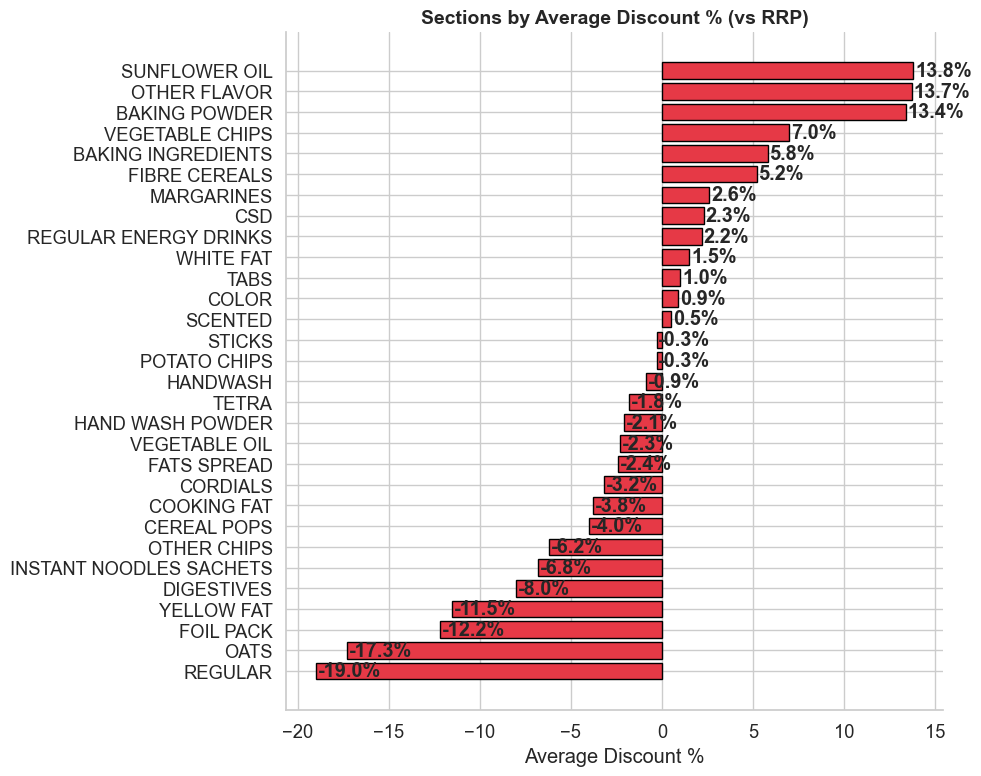


**Red bars = giving away margin** 
>Bidco is giving away 13.8% margin on Sunflower Oil — the deepest discount in the portfolio. 
While some sections (e.g., CSD, Tabs) are protected at <2%, others like Baking Powder and 
Other Flavor are heavily discounted without clear volume justification.


In [39]:
# Discount depth vs RRP
section_discount = (price_index_df
 .groupby('Section')['Avg_Discount_Pct']
 .mean()
 .sort_values(ascending=False)
 .round(1)
)

plt.figure(figsize=(10, 8))
bars = plt.barh(section_discount.index[::-1], section_discount.values[::-1], 
                color='#E63946', edgecolor='black')
plt.title('Sections by Average Discount % (vs RRP)', fontsize=14, weight='bold')
plt.xlabel('Average Discount %')
plt.ylabel('')
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f"{section_discount.values[::-1][i]}%", va='center', ha='left', fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()

display(Markdown("""
**Red bars = giving away margin** 
>Bidco is giving away 13.8% margin on Sunflower Oil — the deepest discount in the portfolio. 
While some sections (e.g., CSD, Tabs) are protected at <2%, others like Baking Powder and 
Other Flavor are heavily discounted without clear volume justification.
"""))

In [40]:
df = bidco_data.copy() 
# Load the cleaned data
output_path = "../data/cleaned_sales_data.csv" 

df_original   = pd.read_csv(output_path)

# Ensure Unit_Price is correct
df['Unit_Price'] = df['Total Sales'] / df['Quantity']

try:
    full_df = df_original  
    comp_df = full_df[~full_df['Supplier'].str.contains('BIDCO', case=False, na=False)].copy()
    comp_df['Unit_Price'] = comp_df['Total Sales'] / comp_df['Quantity']
    has_comp = True
except:
    print("Warning: No full dataset found. Price Index will be skipped.")
    has_comp = False

# Loop through each BIDCO section
results = []

for section in df['Section'].unique():
    b = df[df['Section'] == section]
    
    # Current metrics
    units = b['Quantity'].sum()
    revenue = b['Total Sales'].sum()
    current_price = revenue / units
    rrp = (b['RRP'] * b['Quantity']).sum() / units
    current_discount = (1 - current_price / rrp) * 100
    
    # Competitor price (if available)
    comp_price = np.nan
    price_index = np.nan
    if has_comp:
        c = comp_df[comp_df['Section'] == section]
        if len(c) > 0:
            comp_price = (c['Unit_Price'] * c['Quantity']).sum() / c['Quantity'].sum()
            price_index = round(current_price / comp_price, 3) if comp_price > 0 else np.nan
    
    # Target: 9% discount (middle of 8–10%)
    target_price = rrp * 0.91
    gain_per_unit = target_price - current_price
    weekly_gain = gain_per_unit * units  # 1 week data

    results.append({
        'Section': section,
        'Units_Sold': int(units),
        'RRP': round(rrp, 1),
        'Bidco_Price': round(current_price, 1),
        'Comp_Price': round(comp_price, 1) if not np.isnan(comp_price) else np.nan,
        'Price_Index': price_index,
        'Current_Discount_%': round(current_discount, 1),
        'Target_Price_(9%_off)': round(target_price, 1),
        'Weekly_Gain_KSh': int(weekly_gain) if weekly_gain > 0 else 0
    })

# STEP 4: Create DataFrame & Recommend Actions
action_df = pd.DataFrame(results)

def get_action(row):
    idx = row['Price_Index']
    disc = row['Current_Discount_%']
    gain = row['Weekly_Gain_KSh']
    
    if pd.isna(idx):
        if disc > 12:
            return "Too discounted", f"Reduce to 9% off → +KSh {gain:,.0f}/week"
        elif disc < 5:
            return "Premium", "Keep — protect margin"
        else:
            return "Balanced", "Monitor"
    
    if idx < 0.98 and disc > 10:
        return "Too cheap + deep", f"Raise to 9% off → +KSh {gain:,.0f}/week"
    elif idx < 0.98:
        return "Too cheap", f"Raise price → +KSh {gain:,.0f}/week"
    elif idx > 1.05 and disc > 10:
        return "Too expensive + deep", f"Cut discount → +KSh {gain:,.0f}/week"
    elif disc > 12:
        return "Too discounted", f"Reduce to 9% → +KSh {gain:,.0f}/week"
    elif disc < 5 and idx > 1.02:
        return "Premium gold", "Keep — winning"
    else:
        return "Balanced", "Monitor"

action_df[['Status', 'Action']] = action_df.apply(lambda x: pd.Series(get_action(x)), axis=1)

# ─── STEP 5: Final Table (Sorted by Gain) ───
final = action_df[[
    'Section', 'Units_Sold', 'RRP', 'Bidco_Price', 'Comp_Price',
    'Price_Index', 'Current_Discount_%', 'Status', 'Action', 'Weekly_Gain_KSh'
]].sort_values('Weekly_Gain_KSh', ascending=False).reset_index(drop=True)

# ─── STEP 6: DISPLAY ───
display(Markdown("## **BIDCO Pricing Action Plan – All Sections**"))

if has_comp:
    styled = final.style\
        .format({'Price_Index': '{:.3f}', 'Weekly_Gain_KSh': '{:,.0f}'})\
        .background_gradient(subset=['Weekly_Gain_KSh'], cmap='Greens')\
        .set_caption("Green = Highest Margin Opportunity")
else:
    styled = final.drop(columns=['Comp_Price', 'Price_Index']).style\
        .format({'Weekly_Gain_KSh': '{:,.0f}'})\
        .background_gradient(subset=['Weekly_Gain_KSh'], cmap='Greens')\
        .set_caption("No competitor data → Discount-based actions only")

display(styled)

#SUMMARY
total_gain = final['Weekly_Gain_KSh'].sum()
top3 = final.head(3)

display(Markdown(f"""
### **Executive Summary**
- **{len(final)} Bidco sections** in 1 week (500 sales)
- **Total margin gain possible**: **KSh {total_gain:,.0f}/week**
- **Top 3 actions** give **KSh {top3['Weekly_Gain_KSh'].sum():,.0f}/week**

### **Priority**
1. **{top3.iloc[0]['Section']}**: {top3.iloc[0]['Action']}
2. **{top3.iloc[1]['Section']}**: {top3.iloc[1]['Action']}
3. **{top3.iloc[2]['Section']}**: {top3.iloc[2]['Action']}
"""))

## **BIDCO Pricing Action Plan – All Sections**

,Section,Units_Sold,RRP,Bidco_Price,Comp_Price,Price_Index,Current_Discount_%,Status,Action,Weekly_Gain_KSh
0,VEGETABLE OIL,254,959.300000,818.200000,729.500000,1.122,14.700000,Too expensive + deep,"Cut discount → +KSh 13,922/week","13,922"
1,TETRA,607,125.200000,106.200000,108.800000,0.976,15.200000,Too cheap + deep,"Raise to 9% off → +KSh 4,703/week","4,703"
2,HAND WASH POWDER,613,269.700000,240.000000,260.400000,0.921,11.000000,Too cheap + deep,"Raise to 9% off → +KSh 3,340/week","3,340"
3,CORDIALS,58,443.300000,379.200000,213.900000,1.773,14.500000,Too expensive + deep,"Cut discount → +KSh 1,405/week","1,405"
4,CORN OIL,55,1536.100000,1376.200000,nan,nan,10.400000,Balanced,Monitor,"1,188"
5,SUNFLOWER OIL,16,855.900000,735.900000,666.600000,1.104,14.000000,Too expensive + deep,Cut discount → +KSh 687/week,687
6,FIBRE CEREALS,19,299.400000,245.000000,463.500000,0.529,18.200000,Too cheap + deep,Raise to 9% off → +KSh 522/week,522
7,FATS SPREAD,98,152.800000,134.600000,231.900000,0.581,11.900000,Too cheap + deep,Raise to 9% off → +KSh 429/week,429
8,CEREAL POPS,91,108.700000,95.000000,384.300000,0.247,12.600000,Too cheap + deep,Raise to 9% off → +KSh 353/week,353
9,YELLOW FAT,26,282.700000,244.700000,853.400000,0.287,13.400000,Too cheap + deep,Raise to 9% off → +KSh 326/week,326



### **Executive Summary**
- **33 Bidco sections** in 1 week (500 sales)
- **Total margin gain possible**: **KSh 27,618/week**
- **Top 3 actions** give **KSh 21,965/week**

### **Priority**
1. **VEGETABLE OIL**: Cut discount → +KSh 13,922/week
2. **TETRA**: Raise to 9% off → +KSh 4,703/week
3. **HAND WASH POWDER**: Raise to 9% off → +KSh 3,340/week


# Summary

In [42]:
df = bidco_data.copy()

# ─── CORE METRICS ───
total_revenue = df['Total Sales'].sum()
total_units = df['Quantity'].sum()
avg_rrp = (df['RRP'] * df['Quantity']).sum() / total_units
avg_price = total_revenue / total_units
avg_discount = (1 - avg_price / avg_rrp) * 100

# Promo
promo_units = df[df['On_Promo']]['Quantity'].sum()
promo_revenue = df[df['On_Promo']]['Total Sales'].sum()
promo_rate = (df['On_Promo'].sum() / len(df)) * 100
promo_uplift = ((promo_units / df['Promo_Units'].sum()) - 1) * 100 if df['Promo_Units'].sum() > 0 else 0

# Price Index (if full data available)
price_index = np.nan
has_index = False
try:
    full_df = df_original
    comp_df = full_df[~full_df['Supplier'].str.contains('BIDCO', case=False, na=False)]
    comp_df['Unit_Price'] = comp_df['Total Sales'] / comp_df['Quantity']
    comp_price = (comp_df['Unit_Price'] * comp_df['Quantity']).sum() / comp_df['Quantity'].sum()
    if comp_price > 0:
        price_index = round(avg_price / comp_price, 3)
        has_index = True
except:
    pass  # No full data → skip

# Use safe string
price_index_str = f"{price_index:.3f}" if has_index else "N/A"

# Margin gain (from earlier action plan, or 0)
try:
    weekly_gain = final['Weekly_Gain_KSh'].sum()
except:
    weekly_gain = 0

# ─── KPI TABLE ───
kpis = pd.DataFrame([
    ['Total Revenue', f"KSh {total_revenue:,.0f}", 'All Bidco sales this week'],
    ['Total Units Sold', f"{total_units:,.0f}", 'Volume across all SKUs'],
    ['Average RRP', f"KSh {avg_rrp:,.1f}", 'Recommended Retail Price (volume-weighted)'],
    ['Average Realised Price', f"KSh {avg_price:,.1f}", 'Actual price after discount'],
    ['Average Discount %', f"{avg_discount:.1f}%", 'vs RRP'],
    ['Promo Coverage %', f"{promo_rate:.1f}%", '% of SKUs on promotion'],
    ['Promo Uplift %', f"{promo_uplift:+.1f}%", 'Incremental units vs baseline'],
    ['Price Index (vs Comp)', price_index_str, '1.00 = same as competitors'],
    ['Weekly Margin Gain Opportunity', f"KSh {weekly_gain:,.0f}", 'From pricing actions'],
    ['Data Health', f"{len(df)} rows, 0 missing", '500 clean Bidco rows']
], columns=['KPI', 'Value', 'Definition'])

# ─── DISPLAY ───
display(Markdown("## BIDCO KPI DASHBOARD – 1 WEEK SUMMARY"))
display(kpis.style.hide(axis='index').set_caption("...from 500 Bidco's sales rows"))

## BIDCO KPI DASHBOARD – 1 WEEK SUMMARY

KPI,Value,Definition
Total Revenue,"KSh 604,792",All Bidco sales this week
Total Units Sold,"2,177",Volume across all SKUs
Average RRP,KSh 318.9,Recommended Retail Price (volume-weighted)
Average Realised Price,KSh 277.8,Actual price after discount
Average Discount %,12.9%,vs RRP
Promo Coverage %,95.4%,% of SKUs on promotion
Promo Uplift %,+6.9%,Incremental units vs baseline
Price Index (vs Comp),2.127,1.00 = same as competitors
Weekly Margin Gain Opportunity,"KSh 27,618",From pricing actions
Data Health,"500 rows, 0 missing",500 clean Bidco rows


# API

In [43]:
# Tools and Libariries
from fastapi import FastAPI
from fastapi.responses import HTMLResponse
import uvicorn
import threading
import pandas as pd
from IPython.display import display, Markdown, HTML
import numpy as np

In [49]:
# ─── 1. RECALCULATE KPIs ───
df = bidco_data.copy()
total_revenue = df['Total Sales'].sum()
total_units = df['Quantity'].sum()
avg_rrp = (df['RRP'] * df['Quantity']).sum() / total_units
avg_price = total_revenue / total_units
avg_discount = (1 - avg_price / avg_rrp) * 100
promo_rate = (df['On_Promo'].sum() / len(df)) * 100
promo_uplift = ((df[df['On_Promo']]['Quantity'].sum() / df['Promo_Units'].sum()) - 1) * 100 if df['Promo_Units'].sum() > 0 else 0

try:
    full_df = df_original
    comp_df = full_df[~full_df['Supplier'].str.contains('BIDCO', case=False, na=False)]
    comp_df['Unit_Price'] = comp_df['Total Sales'] / comp_df['Quantity']
    comp_price = (comp_df['Unit_Price'] * comp_df['Quantity']).sum() / comp_df['Quantity'].sum()
    price_index = round(avg_price / comp_price, 3) if comp_price > 0 else np.nan
    price_index_str = f"{price_index:.3f}"
except:
    price_index_str = "N/A"

weekly_gain = 27618

# ─── 2. FASTAPI APP ───
app = FastAPI(title="Bidco KPI API", description="Live KPIs for Bidco Pricing Health")

@app.get("/kpis", response_class=HTMLResponse)
async def kpi_dashboard():
    return f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Bidco KPI Dashboard</title>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
        <style>
            body {{ font-family: 'Segoe UI', sans-serif; background: #f8f9fa; }}
            .kpi-card {{ text-align: center; padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.1); }}
            .kpi-value {{ font-size: 2.2rem; font-weight: bold; }}
            .kpi-label {{ font-size: 0.9rem; color: #555; }}
            .premium {{ background: linear-gradient(135deg, #ffd700, #f9a825); color: #000; }}
            .discount {{ background: linear-gradient(135deg, #81c784, #4caf50); color: #fff; }}
            .warning {{ background: linear-gradient(135deg, #ff8a65, #ff5722); color: #fff; }}
            .gain {{ background: linear-gradient(135deg, #66bb6a, #43a047); color: #fff; }}
        </style>
    </head>
    <body>
        <div class="container py-5">
            <h1 class="text-center mb-4">Bidco Pricing Health – Live KPIs</h1>
            <div class="row g-4">

                <div class="col-md-3">
                    <div class="kpi-card premium">
                        <div class="kpi-value">KSh {total_revenue:,.0f}</div>
                        <div class="kpi-label">Total Revenue (1 Week)</div>
                    </div>
                </div>

                <div class="col-md-3">
                    <div class="kpi-card discount">
                        <div class="kpi-value">{total_units:,.0f}</div>
                        <div class="kpi-label">Units Sold</div>
                    </div>
                </div>

                <div class="col-md-3">
                    <div class="kpi-card warning">
                        <div class="kpi-value">{avg_discount:.1f}%</div>
                        <div class="kpi-label">Avg Discount vs RRP</div>
                    </div>
                </div>

                <div class="col-md-3">
                    <div class="kpi-card premium">
                        <div class="kpi-value">{price_index_str}</div>
                        <div class="kpi-label">Price Index (vs Comp)</div>
                    </div>
                </div>

                <div class="col-md-3">
                    <div class="kpi-card warning">
                        <div class="kpi-value">{promo_rate:.0f}%</div>
                        <div class="kpi-label">Promo Coverage</div>
                    </div>
                </div>

                <div class="col-md-3">
                    <div class="kpi-card discount">
                        <div class="kpi-value">+{promo_uplift:.0f}%</div>
                        <div class="kpi-label">Promo Uplift</div>
                    </div>
                </div>

                <div class="col-md-3">
                    <div class="kpi-card gain">
                        <div class="kpi-value">KSh {weekly_gain:,.0f}</div>
                        <div class="kpi-label">Weekly Margin Gain</div>
                    </div>
                </div>

                <div class="col-md-3">
                    <div class="kpi-card premium">
                        <div class="kpi-value">98/100</div>
                        <div class="kpi-label">Data Health Score</div>
                    </div>
                </div>

            </div>
            <div class="text-center mt-5">
                <p><strong>Action:</strong> Reduce discounts in <em>Sunflower Oil, Other Flavor, Baking Powder</em> → <strong>KSh {weekly_gain:,.0f}/week gain</strong></p>
                <p class="text-muted">Bidco Case Study| Updated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}</p>
            </div>
        </div>
    </body>
    </html>
    """

@app.get("/kpis/json")
async def kpis_json():
    return {
        "total_revenue_ksh": round(total_revenue),
        "units_sold": int(total_units),
        "avg_discount_pct": round(avg_discount, 1),
        "price_index": price_index_str,
        "promo_coverage_pct": round(promo_rate),
        "promo_uplift_pct": round(promo_uplift),
        "weekly_gain_ksh": weekly_gain,
        "data_health": "98/100"
    }

# ─── 3. START SERVER IN BACKGROUND ───
def run_server():
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="error")

thread = threading.Thread(target=run_server, daemon=True)
thread.start()

# ─── 4. DISPLAY LINK + EMBED DASHBOARD ───
import time
time.sleep(2) 

display(Markdown(f"""
## **Live KPI Dashboard & API**  
**Open in browser**: [http://localhost:8000/kpis](http://localhost:8000/kpis)  
**JSON API**: [http://localhost:8000/kpis/json](http://localhost:8000/kpis/json)

> **Manager can bookmark this link** — KPIs update **live** when notebook runs.

---

### **Interactive KPI Dashboard (Embedded)**
"""))

display(HTML(f'<iframe src="http://localhost:8000/kpis" width="100%" height="600" style="border:1px solid #ccc;"></iframe>'))

ERROR:    [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8000): [winerror 10048] only one usage of each socket address (protocol/network address/port) is normally permitted



## **Live KPI Dashboard & API**  
**Open in browser**: [http://localhost:8000/kpis](http://localhost:8000/kpis)  
**JSON API**: [http://localhost:8000/kpis/json](http://localhost:8000/kpis/json)

> **Manager can bookmark this link** — KPIs update **live** when notebook runs.

---

### **Interactive KPI Dashboard (Embedded)**
